In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import numpy as np

from obspy.signal.tf_misfit import plot_tfr
# from wavelets import WaveletAnalysis
from os import listdir
from os.path import isfile, join

/root/anaconda3/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [2]:

def plot_wcps (x):
    
    dt = 0.0001

    wa = WaveletAnalysis(x, dt=dt)

    # wavelet power spectrum
    power = wa.wavelet_power

    # scales 
    scales = wa.scales

    # associated time vector
    t = wa.time

    # reconstruction of the original data
    rx = wa.reconstruction()

    T, S = np.meshgrid(t, scales)
    
    return T, S, power


In [3]:

def plot_wps (t):
    
    # constants for the signal
    A1 = 4.
    t1 = .7
    f1 = 1.
    phi1 = 0.

    # generate the signal
    H1 = (np.sign(t - t1) + 1) / 2
    st1 = A1 * (t - t1) * np.exp(-2 * (t - t1))
    st1 *= np.cos(2. * np.pi * f1 * (t - t1) + phi1 * np.pi) * H1
    
    return st1


In [4]:
motor = 'Bearing1_1'
load_path = '../datasets/phm-2012/Learning_set/' + motor + '/'
npy_save_path = '../datasets/phm/phm-2012-wt/'
img_save_path = '../datasets/phm/phm-2012-wt-image/' + motor + '/'

In [5]:
onlyfiles = [f for f in listdir(load_path) if isfile(join(load_path, f))]
onlyfiles.sort()
print('file length = ', len(onlyfiles))

file length =  2803


In [6]:
def cwt(st, dt, w0, fmin, fmax, nf=100, wl='morlet'):
    """
    Continuous Wavelet Transformation in the Frequency Domain.
    .. seealso:: [Kristekova2006]_, eq. (4)
    :param st: time dependent signal.
    :param dt: time step between two samples in st (in seconds)
    :param w0: parameter for the wavelet, tradeoff between time and frequency
        resolution
    :param fmin: minimum frequency (in Hz)
    :param fmax: maximum frequency (in Hz)
    :param nf: number of logarithmically spaced frequencies between fmin and
        fmax
    :param wl: wavelet to use, for now only 'morlet' is implemented
    :return: time frequency representation of st, type numpy.ndarray of complex
        values, shape = (nf, len(st)).
    """
    npts = len(st) * 2
    tmax = (npts - 1) * dt
    t = np.linspace(0., tmax, npts)
    f = np.logspace(np.log10(fmin), np.log10(fmax), nf)

    cwt = np.zeros((npts // 2, nf), dtype=np.complex)

    if wl == 'morlet':

        def psi(t):
            return np.pi ** (-.25) * np.exp(1j * w0 * t) * \
                np.exp(-t ** 2 / 2.)

        def scale(f):
            return w0 / (2 * np.pi * f)
    else:
        raise ValueError('wavelet type "' + wl + '" not defined!')

    nfft = util.next_pow_2(npts) * 2
    sf = np.fft.fft(st, n=nfft)

    # Ignore underflows.
    with np.errstate(under="ignore"):
        for n, _f in enumerate(f):
            a = scale(_f)
            # time shift necessary, because wavelet is defined around t = 0
            psih = psi(-1 * (t - t[-1] / 2.) / a).conjugate() / np.abs(a) ** .5
            psihf = np.fft.fft(psih, n=nfft)
            tminin = int(t[-1] / 2. / (t[1] - t[0]))
            cwt[:, n] = np.fft.ifft(psihf * sf)[tminin:tminin + npts // 2] * \
                (t[1] - t[0])

    return cwt.T

In [7]:
from obspy.imaging.cm import obspy_sequential, obspy_divergent
from obspy.signal import util

def plot_tfr(st, dt=0.01, t0=0., fmin=1., fmax=10., nf=100, w0=6, left=0.1,
             bottom=0.1, h_1=0.2, h_2=0.6, w_1=0.2, w_2=0.6, w_cb=0.01,
             d_cb=0.0, show=True, plot_args=['k', 'k'], clim=0.0,
             cmap=obspy_sequential, mode='absolute', fft_zero_pad_fac=0, figure_name='test.png'):
    """
    Plot time frequency representation, spectrum and time series of the signal.
    :param st: signal, type numpy.ndarray with shape (number of components,
        number of time samples) or (number of timesamples, ) for single
        component data
    :param dt: time step between two samples in st
    :param t0: starting time for plotting
    :param fmin: minimal frequency to be analyzed
    :param fmax: maximal frequency to be analyzed
    :param nf: number of frequencies (will be chosen with logarithmic spacing)
    :param w0: parameter for the wavelet, tradeoff between time and frequency
        resolution
    :param left: plot distance from the left of the figure
    :param bottom: plot distance from the bottom of the figure
    :param h_1: height of the signal axis
    :param h_2: height of the TFR/spectrum axis
    :param w_1: width of the spectrum axis
    :param w_2: width of the TFR/signal axes
    :param w_cb: width of the colorbar axes
    :param d_cb: distance of the colorbar axes to the other axes
    :param show: show figure or return
    :param plot_args: list of plot arguments passed to the signal and spectrum
        plots
    :param clim: limits of the colorbars
    :param cmap: colormap for TFEM/TFPM, either a string or
        matplotlib.cm.Colormap instance
    :param mode: 'absolute' for absolute value of TFR, 'power' for ``|TFR|^2``
    :param fft_zero_pad_fac: integer, if > 0, the signal is zero padded to
        ``nfft = next_pow_2(len(st)) * fft_zero_pad_fac`` to get smoother
        spectrum in the low frequencies (has no effect on the TFR and might
        make demeaning/tapering necessary to avoid artifacts)
    :return: If show is False, returns a matplotlib.pyplot.figure object
        (single component data) or a list of figure objects (multi component
        data)
    .. rubric:: Example
    >>> from obspy import read
    >>> tr = read("https://examples.obspy.org/a02i.2008.240.mseed")[0]
    >>> plot_tfr(tr.data, dt=tr.stats.delta, fmin=.01, # doctest: +SKIP
    ...         fmax=50., w0=8., nf=64, fft_zero_pad_fac=4)
    .. plot::
        from obspy.signal.tf_misfit import plot_tfr
        from obspy import read
        tr = read("https://examples.obspy.org/a02i.2008.240.mseed")[0]
        plot_tfr(tr.data, dt=tr.stats.delta, fmin=.01,
                fmax=50., w0=8., nf=64, fft_zero_pad_fac=4)
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullFormatter
    npts = st.shape[-1]
    tmax = (npts - 1) * dt
    t = np.linspace(0., tmax, npts) + t0

    if fft_zero_pad_fac == 0:
        nfft = npts
    else:
        nfft = util.next_pow_2(npts) * fft_zero_pad_fac

    f_lin = np.linspace(0, 0.5 / dt, nfft // 2 + 1)

    if len(st.shape) == 1:
        _w = np.zeros((1, nf, npts), dtype=np.complex)
        _w[0] = cwt(st, dt, w0, fmin, fmax, nf)
        ntr = 1

        spec = np.zeros((1, nfft // 2 + 1), dtype=np.complex)
        spec[0] = np.fft.rfft(st, n=nfft) * dt

        st = st.reshape((1, npts))
    else:
        _w = np.zeros((st.shape[0], nf, npts), dtype=np.complex)
        spec = np.zeros((st.shape[0], nfft // 2 + 1), dtype=np.complex)

        for i in np.arange(st.shape[0]):
            _w[i] = cwt(st[i], dt, w0, fmin, fmax, nf)
            spec[i] = np.fft.rfft(st[i], n=nfft) * dt

        ntr = st.shape[0]

    if mode == 'absolute':
        _tfr = np.abs(_w)
        spec = np.abs(spec)
    elif mode == 'power':
        _tfr = np.abs(_w) ** 2
        spec = np.abs(spec) ** 2
    else:
        raise ValueError('mode "' + mode + '" not defined!')

    figs = []

    for itr in np.arange(ntr):
        fig = plt.figure()

#         # plot signals
#         ax_sig = fig.add_axes([left + w_1, bottom, w_2, h_1])
#         ax_sig.plot(t, st[itr], plot_args[0])

        # plot TFR
        ax_tfr = fig.add_axes([left + w_1, bottom + h_1, w_2, h_2])

        x, y = np.meshgrid(
            t, np.logspace(np.log10(fmin), np.log10(fmax),
                           _tfr[itr].shape[0]))
        img_tfr = ax_tfr.pcolormesh(x, y, _tfr[itr], cmap=cmap)
        
#         return_numpy = img_tfr.get_array().reshape(img_tfr._meshWidth, img_tfr._meshHeight)
        
#         print(return_numpy.shape)
#         print (x.shape, y.shape, img_tfr.get_array().shape, img_tfr._meshWidth, img_tfr._meshHeight)
        
        img_tfr.set_rasterized(True)
        ax_tfr.set_yscale("log")
        ax_tfr.set_ylim(fmin, fmax)
        ax_tfr.set_xlim(t[0], t[-1])
        
        plt.axis('off')
        plt.show()
        plt.savefig(img_save_path+figure_name, 
                    pad_inches = 0, 
                    bbox_inches = 'tight', 
                    dpi=300)
        

#         # plot spectrum
#         ax_spec = fig.add_axes([left, bottom + h_1, w_1, h_2])
#         ax_spec.semilogy(spec[itr], f_lin, plot_args[1])

#         # add colorbars
#         ax_cb_tfr = fig.add_axes([left + w_1 + w_2 + d_cb + w_cb, bottom +
#                                   h_1, w_cb, h_2])
#         fig.colorbar(img_tfr, cax=ax_cb_tfr)

#         # set limits
#         ax_sig.set_ylim(st.min() * 1.1, st.max() * 1.1)
#         ax_sig.set_xlim(t[0], t[-1])

#         xlim = spec.max() * 1.1

#         ax_spec.set_xlim(xlim, 0.)
#         ax_spec.set_ylim(fmin, fmax)

#         if clim == 0.:
#             clim = _tfr.max()

#         img_tfr.set_clim(0., clim)

#         ax_sig.set_xlabel('time')
#         ax_spec.set_ylabel('frequency')

#         # remove axis labels
#         ax_tfr.xaxis.set_major_formatter(NullFormatter())
#         ax_tfr.yaxis.set_major_formatter(NullFormatter())

#         figs.append(fig)
    
    return img_tfr

#     if show:
#         plt.show()
        
#     else:
#         if ntr == 1:
#             return figs[0]
#         else:
#             return figs

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00001.csv


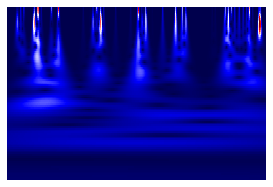

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00002.csv


<Figure size 432x288 with 0 Axes>

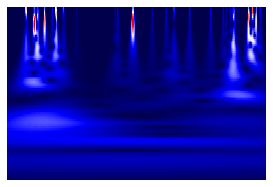

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00003.csv


<Figure size 432x288 with 0 Axes>

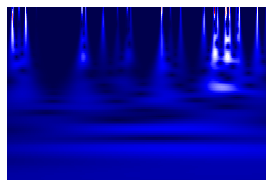

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00004.csv


<Figure size 432x288 with 0 Axes>

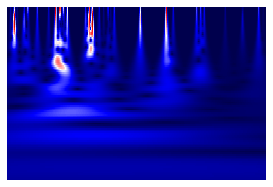

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00005.csv


<Figure size 432x288 with 0 Axes>

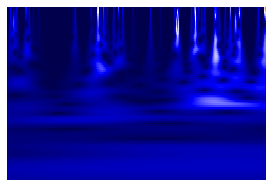

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00006.csv


<Figure size 432x288 with 0 Axes>

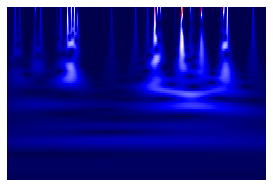

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00007.csv


<Figure size 432x288 with 0 Axes>

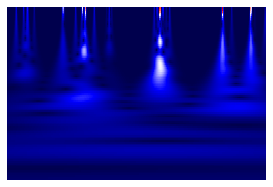

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00008.csv


<Figure size 432x288 with 0 Axes>

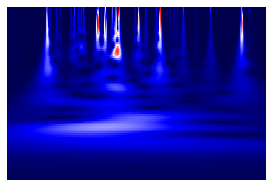

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00009.csv


<Figure size 432x288 with 0 Axes>

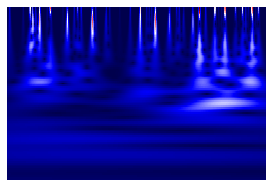

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00010.csv


<Figure size 432x288 with 0 Axes>

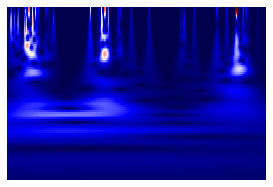

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00011.csv


<Figure size 432x288 with 0 Axes>

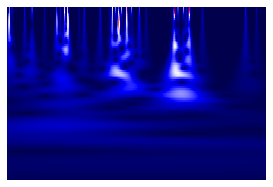

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00012.csv


<Figure size 432x288 with 0 Axes>

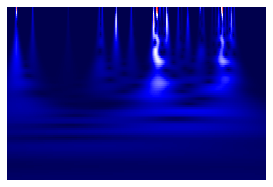

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00013.csv


<Figure size 432x288 with 0 Axes>

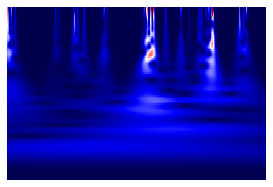

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00014.csv


<Figure size 432x288 with 0 Axes>

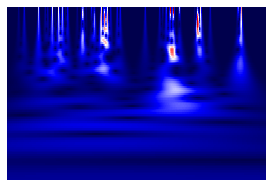

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00015.csv


<Figure size 432x288 with 0 Axes>

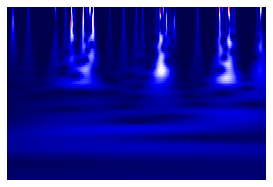

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00016.csv


<Figure size 432x288 with 0 Axes>

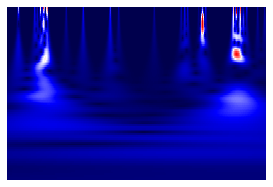

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00017.csv


<Figure size 432x288 with 0 Axes>

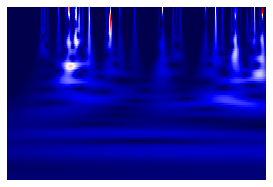

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00018.csv


<Figure size 432x288 with 0 Axes>

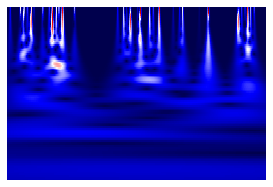

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00019.csv


<Figure size 432x288 with 0 Axes>

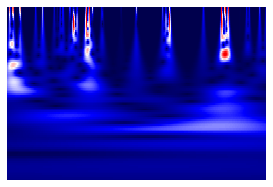

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00020.csv


<Figure size 432x288 with 0 Axes>

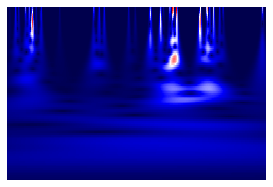

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00021.csv


<Figure size 432x288 with 0 Axes>

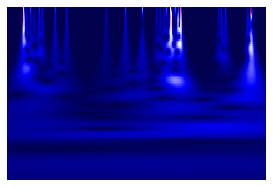

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00022.csv


<Figure size 432x288 with 0 Axes>

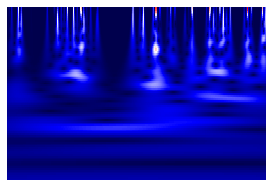

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00023.csv


<Figure size 432x288 with 0 Axes>

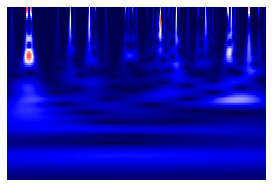

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00024.csv


<Figure size 432x288 with 0 Axes>

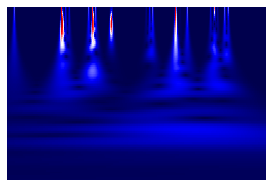

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00025.csv


<Figure size 432x288 with 0 Axes>

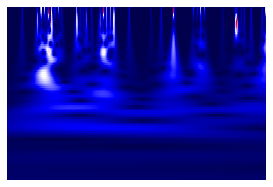

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00026.csv


<Figure size 432x288 with 0 Axes>

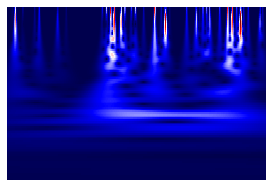

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00027.csv


<Figure size 432x288 with 0 Axes>

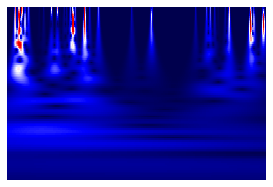

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00028.csv


<Figure size 432x288 with 0 Axes>

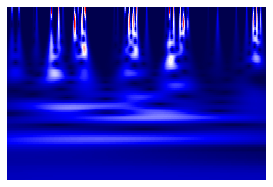

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00029.csv


<Figure size 432x288 with 0 Axes>

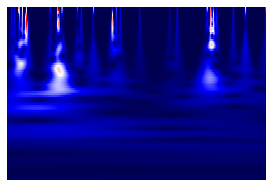

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00030.csv


<Figure size 432x288 with 0 Axes>

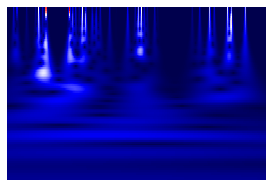

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00031.csv


<Figure size 432x288 with 0 Axes>

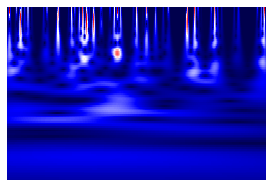

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00032.csv


<Figure size 432x288 with 0 Axes>

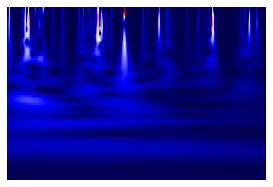

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00033.csv


<Figure size 432x288 with 0 Axes>

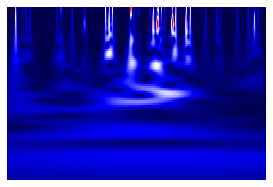

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00034.csv


<Figure size 432x288 with 0 Axes>

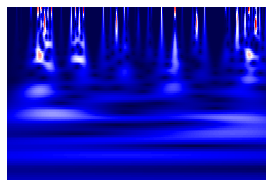

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00035.csv


<Figure size 432x288 with 0 Axes>

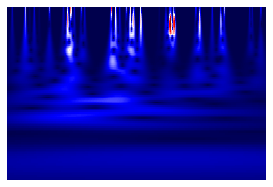

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00036.csv


<Figure size 432x288 with 0 Axes>

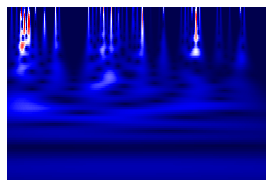

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00037.csv


<Figure size 432x288 with 0 Axes>

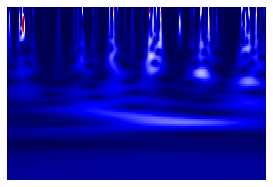

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00038.csv


<Figure size 432x288 with 0 Axes>

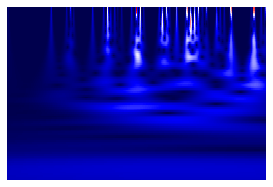

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00039.csv


<Figure size 432x288 with 0 Axes>

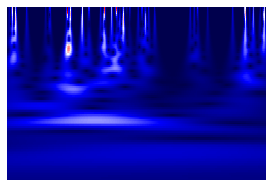

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00040.csv


<Figure size 432x288 with 0 Axes>

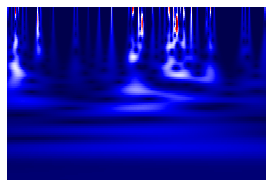

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00041.csv


<Figure size 432x288 with 0 Axes>

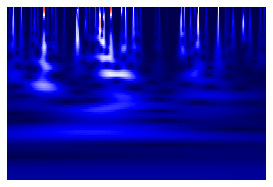

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00042.csv


<Figure size 432x288 with 0 Axes>

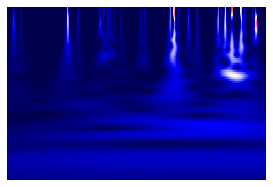

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00043.csv


<Figure size 432x288 with 0 Axes>

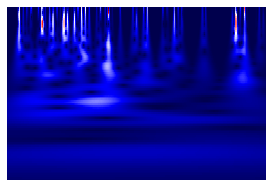

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00044.csv


<Figure size 432x288 with 0 Axes>

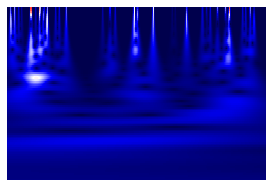

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00045.csv


<Figure size 432x288 with 0 Axes>

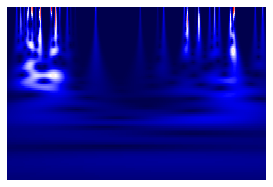

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00046.csv


<Figure size 432x288 with 0 Axes>

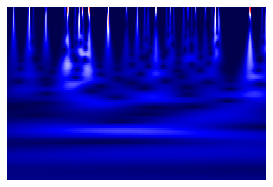

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00047.csv


<Figure size 432x288 with 0 Axes>

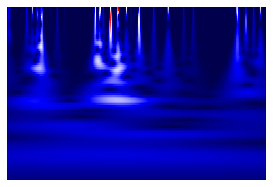

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00048.csv


<Figure size 432x288 with 0 Axes>

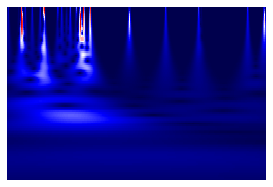

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00049.csv


<Figure size 432x288 with 0 Axes>

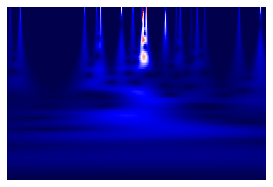

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00050.csv


<Figure size 432x288 with 0 Axes>

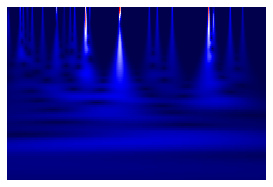

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00051.csv


<Figure size 432x288 with 0 Axes>

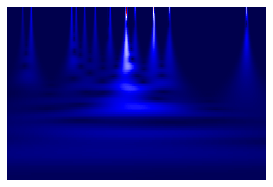

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00052.csv


<Figure size 432x288 with 0 Axes>

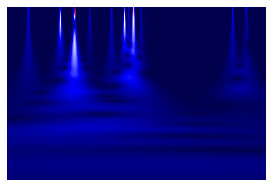

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00053.csv


<Figure size 432x288 with 0 Axes>

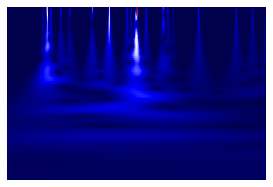

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00054.csv


<Figure size 432x288 with 0 Axes>

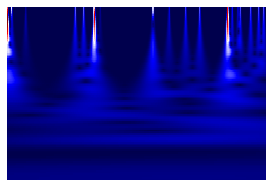

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00055.csv


<Figure size 432x288 with 0 Axes>

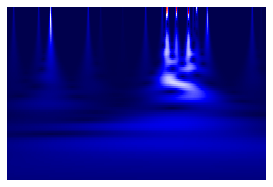

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00056.csv


<Figure size 432x288 with 0 Axes>

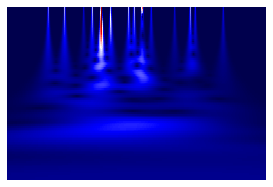

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00057.csv


<Figure size 432x288 with 0 Axes>

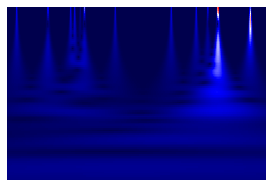

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00058.csv


<Figure size 432x288 with 0 Axes>

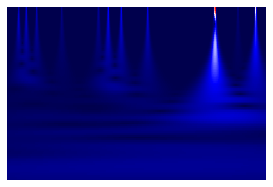

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00059.csv


<Figure size 432x288 with 0 Axes>

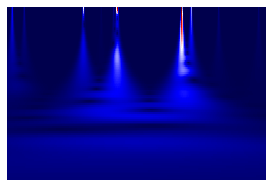

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00060.csv


<Figure size 432x288 with 0 Axes>

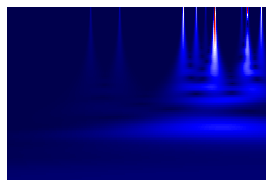

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00061.csv


<Figure size 432x288 with 0 Axes>

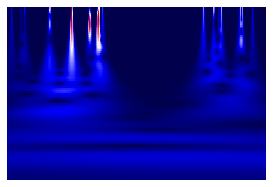

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00062.csv


<Figure size 432x288 with 0 Axes>

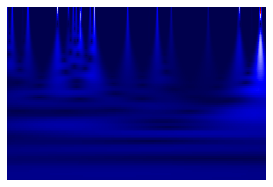

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00063.csv


<Figure size 432x288 with 0 Axes>

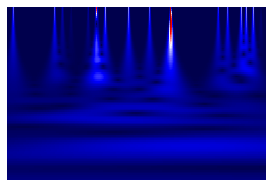

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00064.csv


<Figure size 432x288 with 0 Axes>

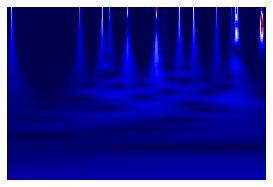

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00065.csv


<Figure size 432x288 with 0 Axes>

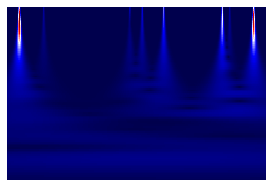

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00066.csv


<Figure size 432x288 with 0 Axes>

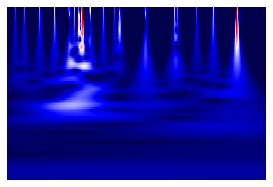

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00067.csv


<Figure size 432x288 with 0 Axes>

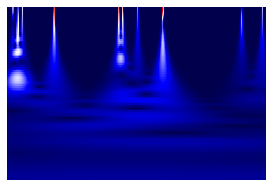

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00068.csv


<Figure size 432x288 with 0 Axes>

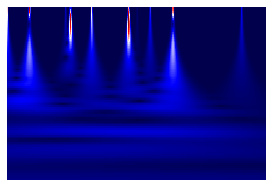

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00069.csv


<Figure size 432x288 with 0 Axes>

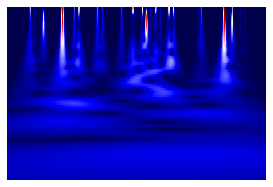

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00070.csv


<Figure size 432x288 with 0 Axes>

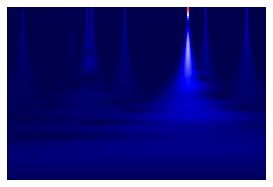

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00071.csv


<Figure size 432x288 with 0 Axes>

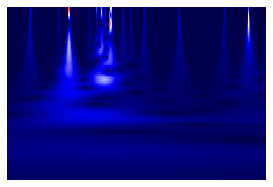

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00072.csv


<Figure size 432x288 with 0 Axes>

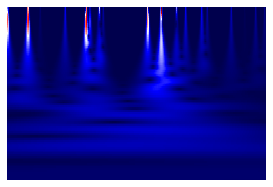

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00073.csv


<Figure size 432x288 with 0 Axes>

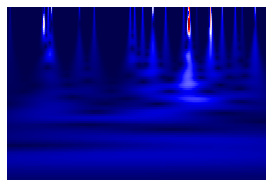

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00074.csv


<Figure size 432x288 with 0 Axes>

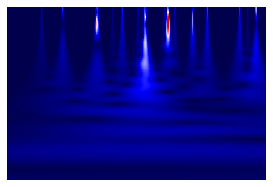

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00075.csv


<Figure size 432x288 with 0 Axes>

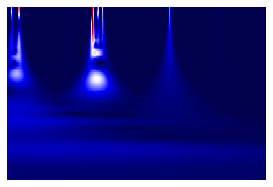

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00076.csv


<Figure size 432x288 with 0 Axes>

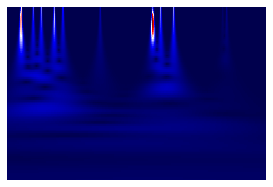

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00077.csv


<Figure size 432x288 with 0 Axes>

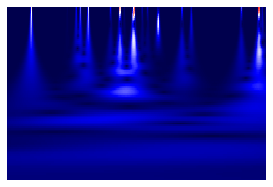

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00078.csv


<Figure size 432x288 with 0 Axes>

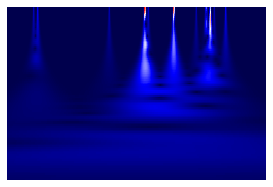

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00079.csv


<Figure size 432x288 with 0 Axes>

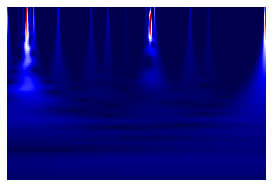

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00080.csv


<Figure size 432x288 with 0 Axes>

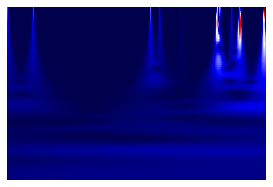

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00081.csv


<Figure size 432x288 with 0 Axes>

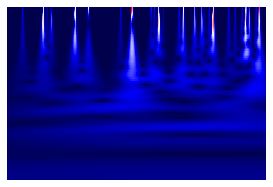

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00082.csv


<Figure size 432x288 with 0 Axes>

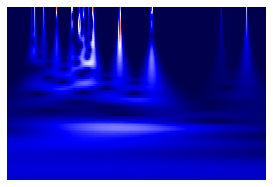

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00083.csv


<Figure size 432x288 with 0 Axes>

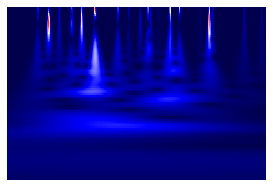

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00084.csv


<Figure size 432x288 with 0 Axes>

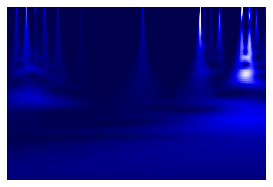

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00085.csv


<Figure size 432x288 with 0 Axes>

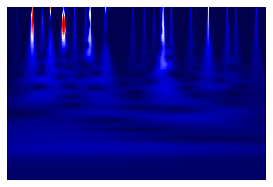

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00086.csv


<Figure size 432x288 with 0 Axes>

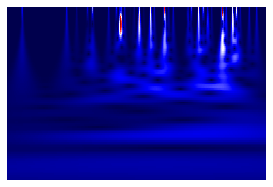

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00087.csv


<Figure size 432x288 with 0 Axes>

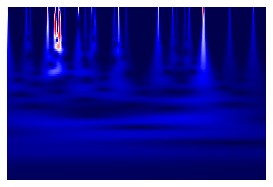

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00088.csv


<Figure size 432x288 with 0 Axes>

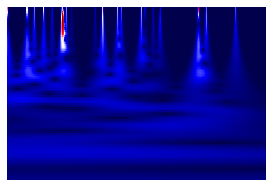

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00089.csv


<Figure size 432x288 with 0 Axes>

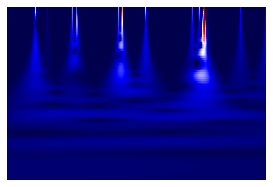

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00090.csv


<Figure size 432x288 with 0 Axes>

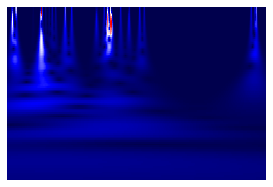

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00091.csv


<Figure size 432x288 with 0 Axes>

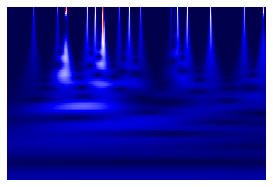

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00092.csv


<Figure size 432x288 with 0 Axes>

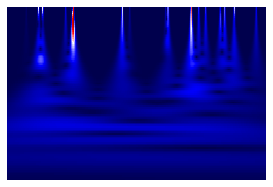

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00093.csv


<Figure size 432x288 with 0 Axes>

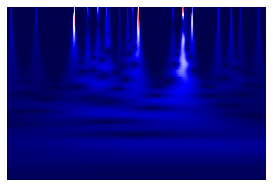

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00094.csv


<Figure size 432x288 with 0 Axes>

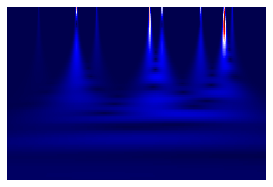

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00095.csv


<Figure size 432x288 with 0 Axes>

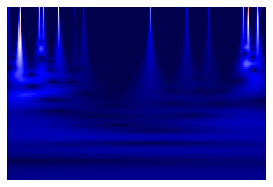

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00096.csv


<Figure size 432x288 with 0 Axes>

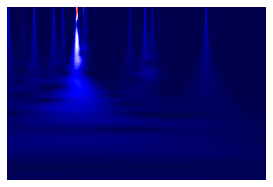

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00097.csv


<Figure size 432x288 with 0 Axes>

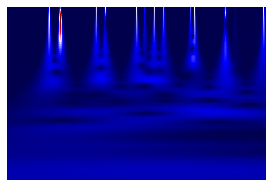

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00098.csv


<Figure size 432x288 with 0 Axes>

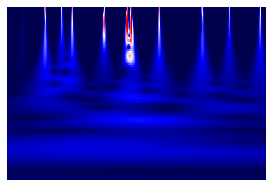

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00099.csv


<Figure size 432x288 with 0 Axes>

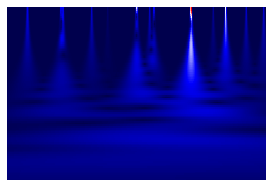

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00100.csv


<Figure size 432x288 with 0 Axes>

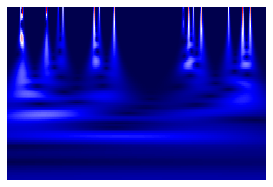

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00101.csv


<Figure size 432x288 with 0 Axes>

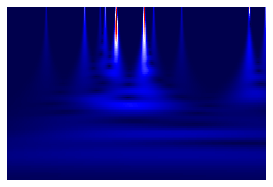

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00102.csv


<Figure size 432x288 with 0 Axes>

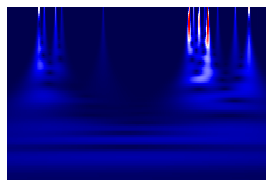

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00103.csv


<Figure size 432x288 with 0 Axes>

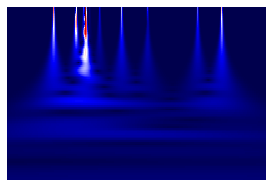

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00104.csv


<Figure size 432x288 with 0 Axes>

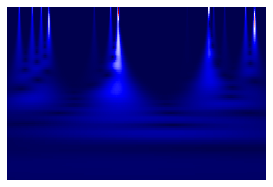

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00105.csv


<Figure size 432x288 with 0 Axes>

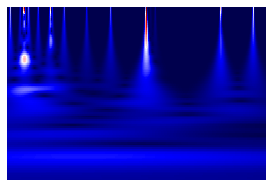

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00106.csv


<Figure size 432x288 with 0 Axes>

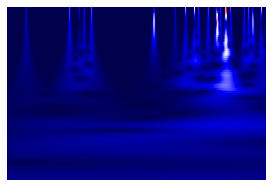

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00107.csv


<Figure size 432x288 with 0 Axes>

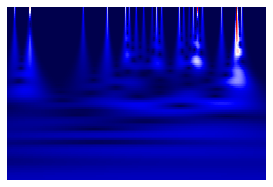

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00108.csv


<Figure size 432x288 with 0 Axes>

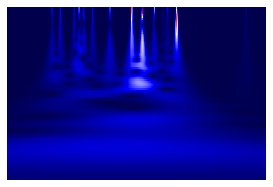

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00109.csv


<Figure size 432x288 with 0 Axes>

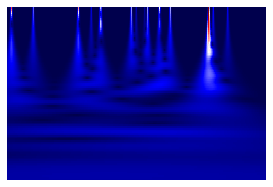

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00110.csv


<Figure size 432x288 with 0 Axes>

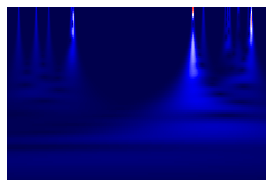

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00111.csv


<Figure size 432x288 with 0 Axes>

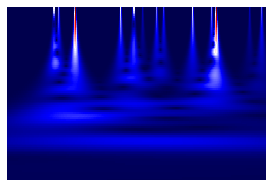

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00112.csv


<Figure size 432x288 with 0 Axes>

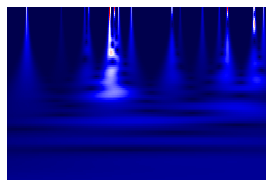

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00113.csv


<Figure size 432x288 with 0 Axes>

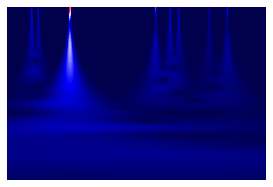

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00114.csv


<Figure size 432x288 with 0 Axes>

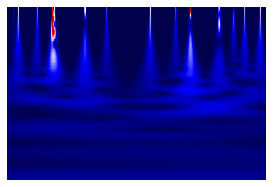

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00115.csv


<Figure size 432x288 with 0 Axes>

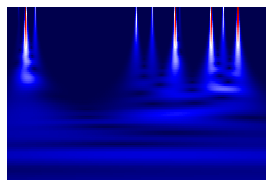

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00116.csv


<Figure size 432x288 with 0 Axes>

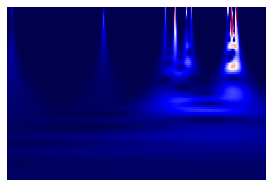

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00117.csv


<Figure size 432x288 with 0 Axes>

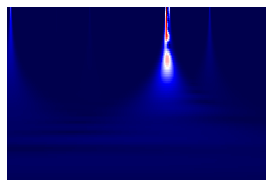

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00118.csv


<Figure size 432x288 with 0 Axes>

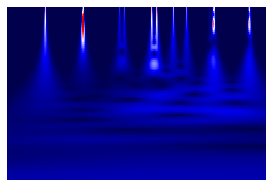

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00119.csv


<Figure size 432x288 with 0 Axes>

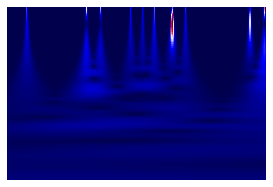

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00120.csv


<Figure size 432x288 with 0 Axes>

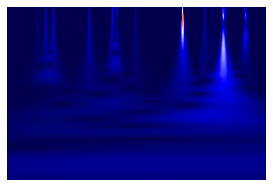

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00121.csv


<Figure size 432x288 with 0 Axes>

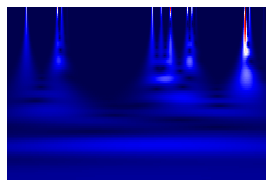

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00122.csv


<Figure size 432x288 with 0 Axes>

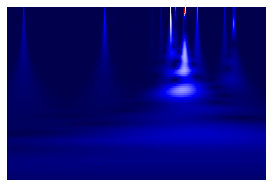

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00123.csv


<Figure size 432x288 with 0 Axes>

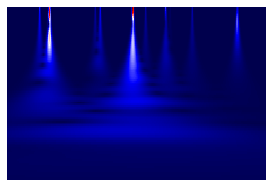

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00124.csv


<Figure size 432x288 with 0 Axes>

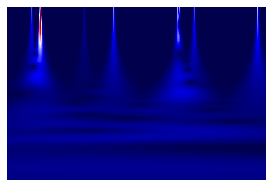

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00125.csv


<Figure size 432x288 with 0 Axes>

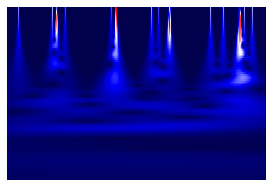

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00126.csv


<Figure size 432x288 with 0 Axes>

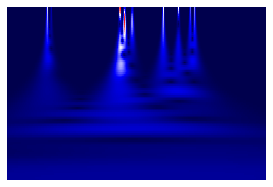

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00127.csv


<Figure size 432x288 with 0 Axes>

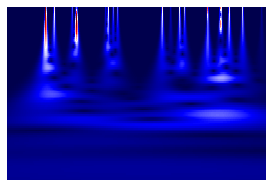

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00128.csv


<Figure size 432x288 with 0 Axes>

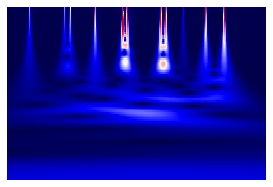

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00129.csv


<Figure size 432x288 with 0 Axes>

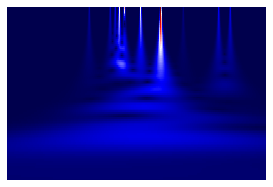

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00130.csv


<Figure size 432x288 with 0 Axes>

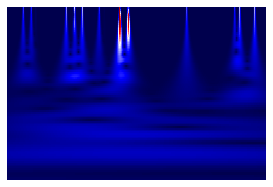

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00131.csv


<Figure size 432x288 with 0 Axes>

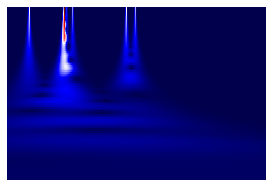

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00132.csv


<Figure size 432x288 with 0 Axes>

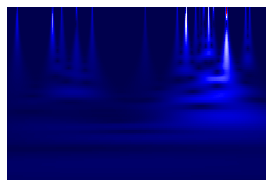

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00133.csv


<Figure size 432x288 with 0 Axes>

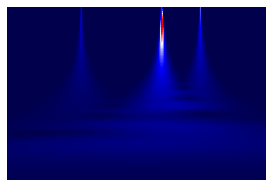

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00134.csv


<Figure size 432x288 with 0 Axes>

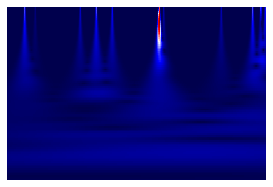

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00135.csv


<Figure size 432x288 with 0 Axes>

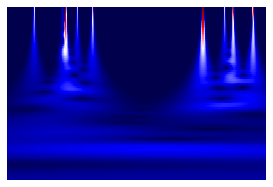

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00136.csv


<Figure size 432x288 with 0 Axes>

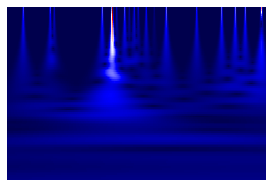

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00137.csv


<Figure size 432x288 with 0 Axes>

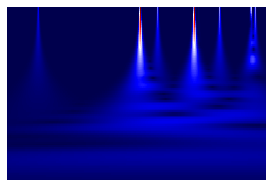

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00138.csv


<Figure size 432x288 with 0 Axes>

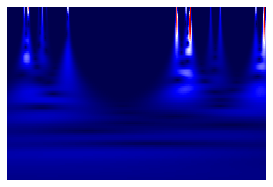

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00139.csv


<Figure size 432x288 with 0 Axes>

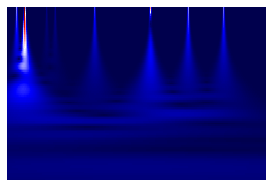

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00140.csv


<Figure size 432x288 with 0 Axes>

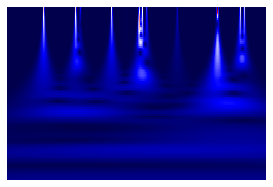

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00141.csv


<Figure size 432x288 with 0 Axes>

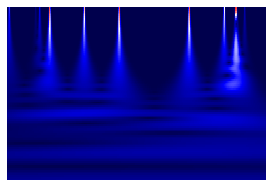

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00142.csv


<Figure size 432x288 with 0 Axes>

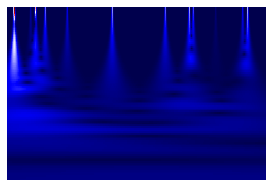

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00143.csv


<Figure size 432x288 with 0 Axes>

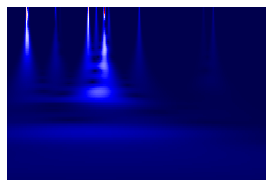

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00144.csv


<Figure size 432x288 with 0 Axes>

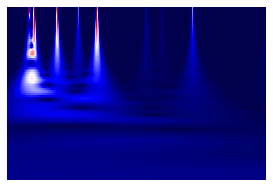

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00145.csv


<Figure size 432x288 with 0 Axes>

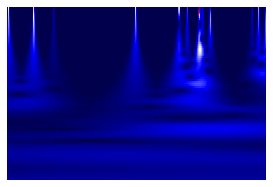

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00146.csv


<Figure size 432x288 with 0 Axes>

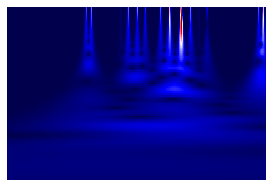

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00147.csv


<Figure size 432x288 with 0 Axes>

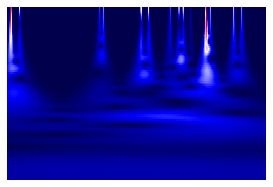

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00148.csv


<Figure size 432x288 with 0 Axes>

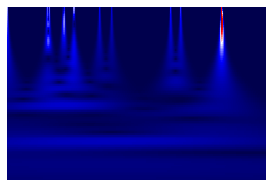

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00149.csv


<Figure size 432x288 with 0 Axes>

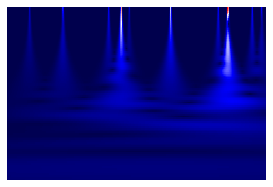

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00150.csv


<Figure size 432x288 with 0 Axes>

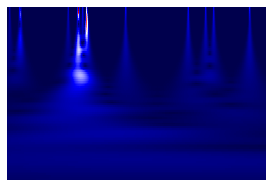

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00151.csv


<Figure size 432x288 with 0 Axes>

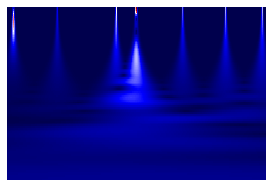

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00152.csv


<Figure size 432x288 with 0 Axes>

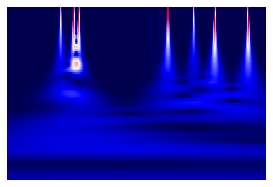

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00153.csv


<Figure size 432x288 with 0 Axes>

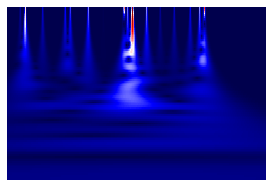

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00154.csv


<Figure size 432x288 with 0 Axes>

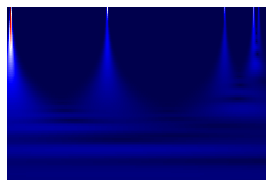

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00155.csv


<Figure size 432x288 with 0 Axes>

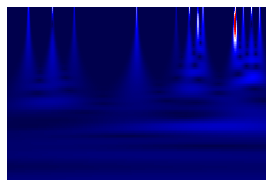

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00156.csv


<Figure size 432x288 with 0 Axes>

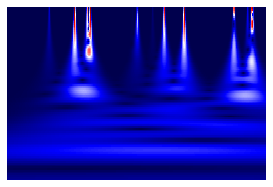

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00157.csv


<Figure size 432x288 with 0 Axes>

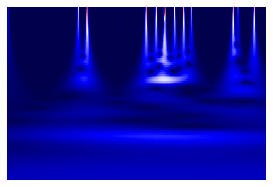

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00158.csv


<Figure size 432x288 with 0 Axes>

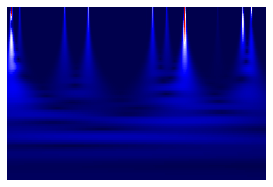

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00159.csv


<Figure size 432x288 with 0 Axes>

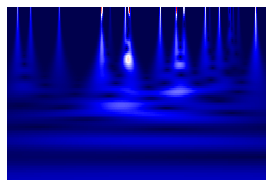

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00160.csv


<Figure size 432x288 with 0 Axes>

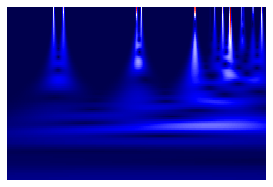

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00161.csv


<Figure size 432x288 with 0 Axes>

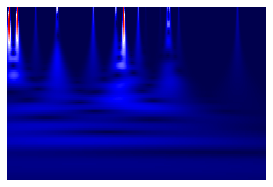

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00162.csv


<Figure size 432x288 with 0 Axes>

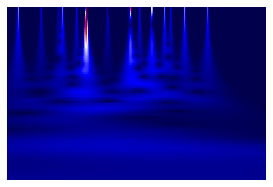

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00163.csv


<Figure size 432x288 with 0 Axes>

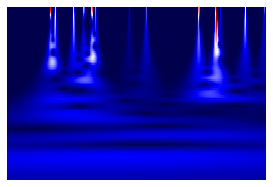

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00164.csv


<Figure size 432x288 with 0 Axes>

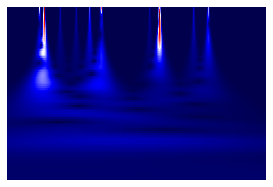

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00165.csv


<Figure size 432x288 with 0 Axes>

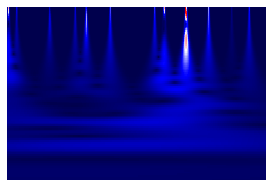

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00166.csv


<Figure size 432x288 with 0 Axes>

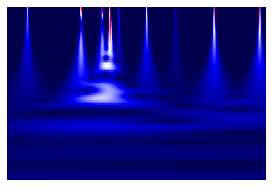

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00167.csv


<Figure size 432x288 with 0 Axes>

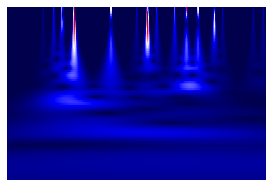

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00168.csv


<Figure size 432x288 with 0 Axes>

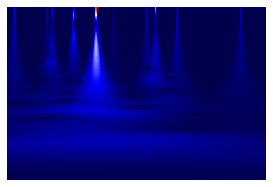

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00169.csv


<Figure size 432x288 with 0 Axes>

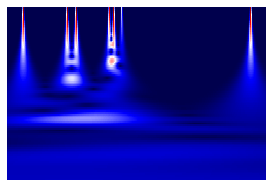

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00170.csv


<Figure size 432x288 with 0 Axes>

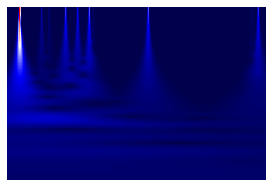

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00171.csv


<Figure size 432x288 with 0 Axes>

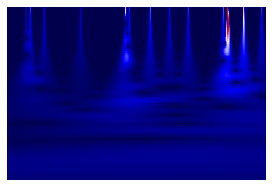

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00172.csv


<Figure size 432x288 with 0 Axes>

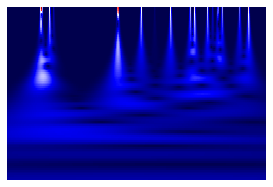

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00173.csv


<Figure size 432x288 with 0 Axes>

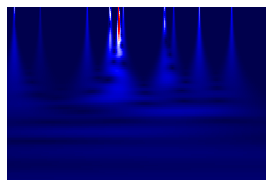

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00174.csv


<Figure size 432x288 with 0 Axes>

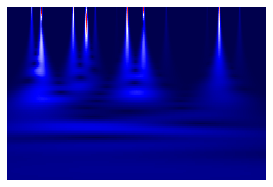

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00175.csv


<Figure size 432x288 with 0 Axes>

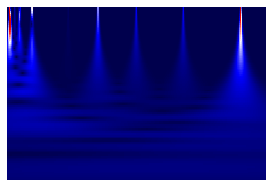

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00176.csv


<Figure size 432x288 with 0 Axes>

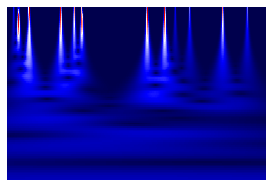

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00177.csv


<Figure size 432x288 with 0 Axes>

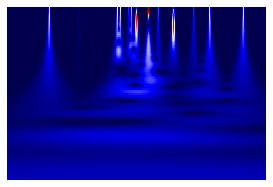

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00178.csv


<Figure size 432x288 with 0 Axes>

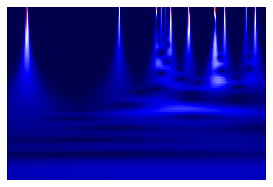

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00179.csv


<Figure size 432x288 with 0 Axes>

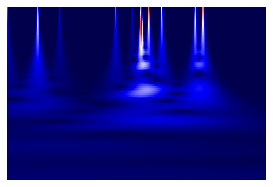

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00180.csv


<Figure size 432x288 with 0 Axes>

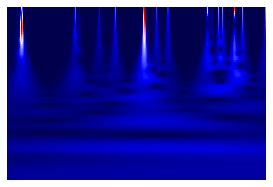

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00181.csv


<Figure size 432x288 with 0 Axes>

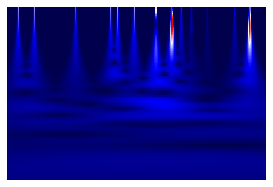

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00182.csv


<Figure size 432x288 with 0 Axes>

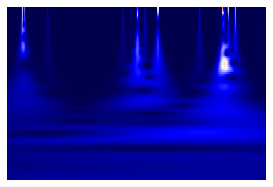

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00183.csv


<Figure size 432x288 with 0 Axes>

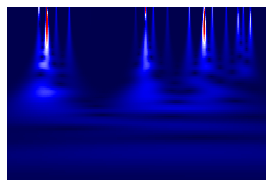

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00184.csv


<Figure size 432x288 with 0 Axes>

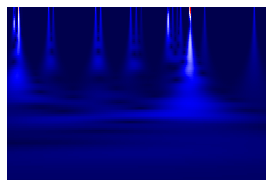

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00185.csv


<Figure size 432x288 with 0 Axes>

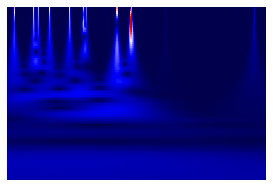

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00186.csv


<Figure size 432x288 with 0 Axes>

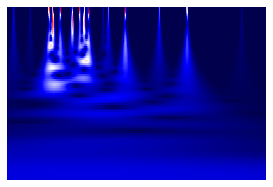

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00187.csv


<Figure size 432x288 with 0 Axes>

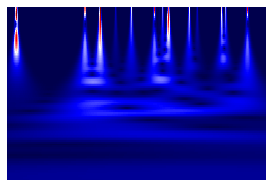

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00188.csv


<Figure size 432x288 with 0 Axes>

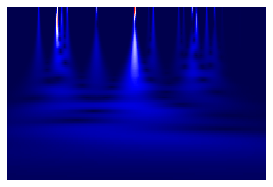

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00189.csv


<Figure size 432x288 with 0 Axes>

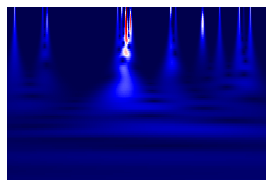

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00190.csv


<Figure size 432x288 with 0 Axes>

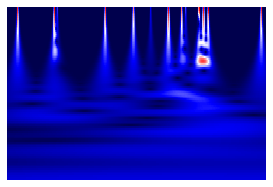

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00191.csv


<Figure size 432x288 with 0 Axes>

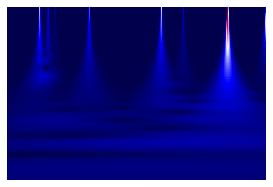

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00192.csv


<Figure size 432x288 with 0 Axes>

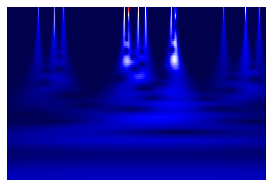

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00193.csv


<Figure size 432x288 with 0 Axes>

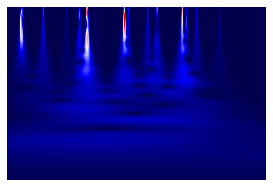

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00194.csv


<Figure size 432x288 with 0 Axes>

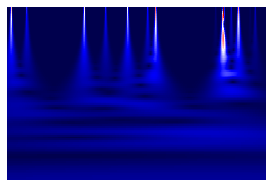

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00195.csv


<Figure size 432x288 with 0 Axes>

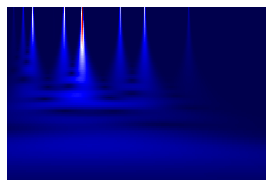

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00196.csv


<Figure size 432x288 with 0 Axes>

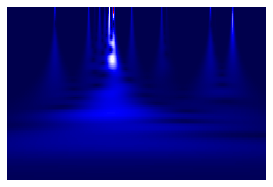

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00197.csv


<Figure size 432x288 with 0 Axes>

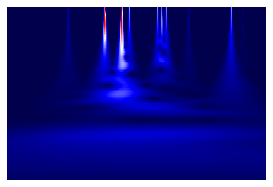

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00198.csv


<Figure size 432x288 with 0 Axes>

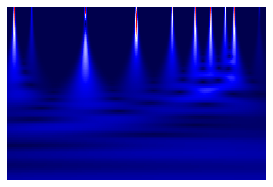

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00199.csv


<Figure size 432x288 with 0 Axes>

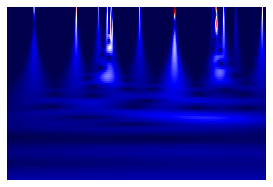

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00200.csv


<Figure size 432x288 with 0 Axes>

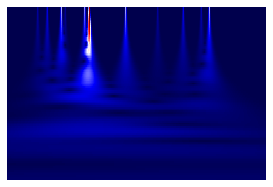

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00201.csv


<Figure size 432x288 with 0 Axes>

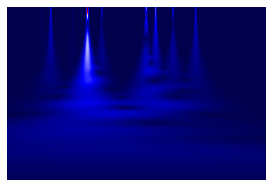

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00202.csv


<Figure size 432x288 with 0 Axes>

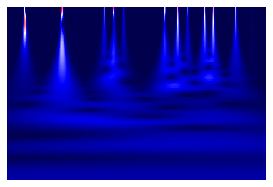

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00203.csv


<Figure size 432x288 with 0 Axes>

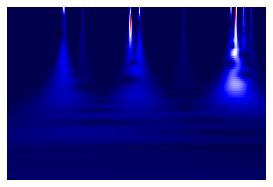

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00204.csv


<Figure size 432x288 with 0 Axes>

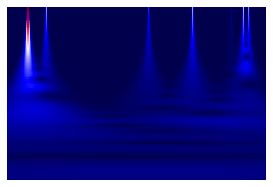

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00205.csv


<Figure size 432x288 with 0 Axes>

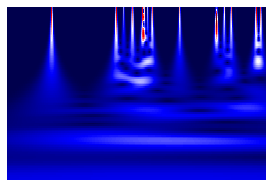

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00206.csv


<Figure size 432x288 with 0 Axes>

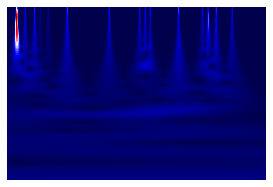

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00207.csv


<Figure size 432x288 with 0 Axes>

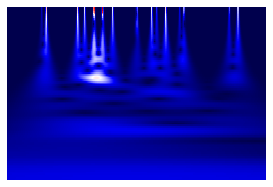

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00208.csv


<Figure size 432x288 with 0 Axes>

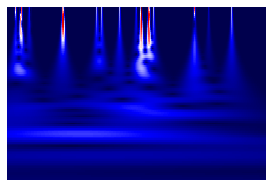

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00209.csv


<Figure size 432x288 with 0 Axes>

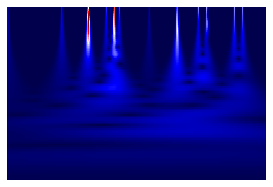

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00210.csv


<Figure size 432x288 with 0 Axes>

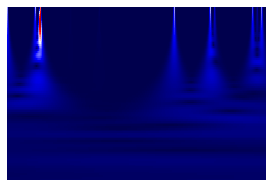

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00211.csv


<Figure size 432x288 with 0 Axes>

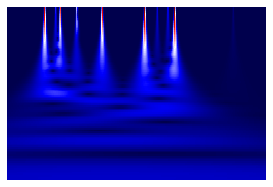

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00212.csv


<Figure size 432x288 with 0 Axes>

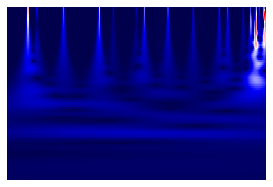

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00213.csv


<Figure size 432x288 with 0 Axes>

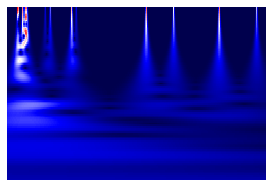

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00214.csv


<Figure size 432x288 with 0 Axes>

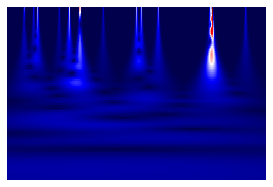

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00215.csv


<Figure size 432x288 with 0 Axes>

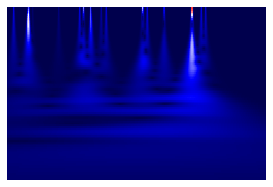

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00216.csv


<Figure size 432x288 with 0 Axes>

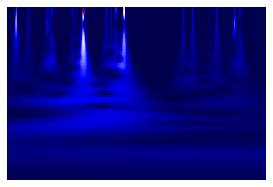

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00217.csv


<Figure size 432x288 with 0 Axes>

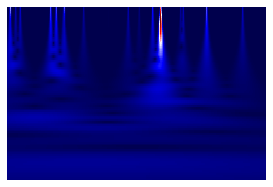

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00218.csv


<Figure size 432x288 with 0 Axes>

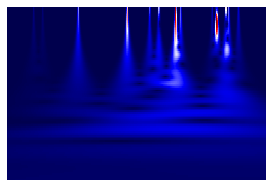

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00219.csv


<Figure size 432x288 with 0 Axes>

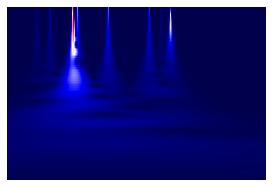

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00220.csv


<Figure size 432x288 with 0 Axes>

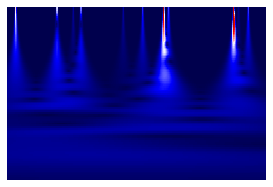

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00221.csv


<Figure size 432x288 with 0 Axes>

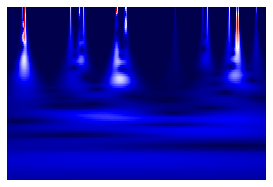

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00222.csv


<Figure size 432x288 with 0 Axes>

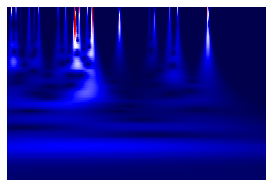

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00223.csv


<Figure size 432x288 with 0 Axes>

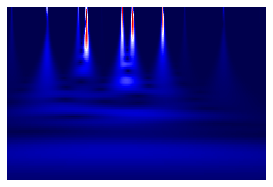

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00224.csv


<Figure size 432x288 with 0 Axes>

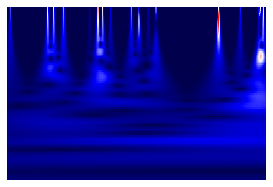

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00225.csv


<Figure size 432x288 with 0 Axes>

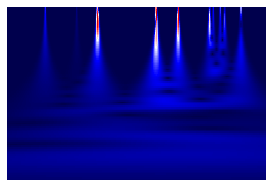

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00226.csv


<Figure size 432x288 with 0 Axes>

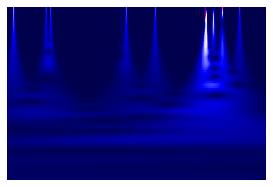

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00227.csv


<Figure size 432x288 with 0 Axes>

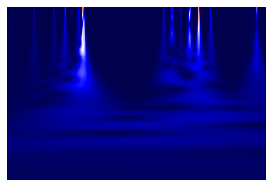

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00228.csv


<Figure size 432x288 with 0 Axes>

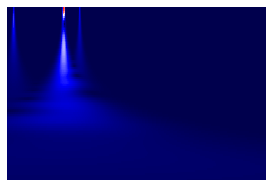

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00229.csv


<Figure size 432x288 with 0 Axes>

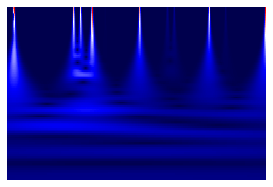

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00230.csv


<Figure size 432x288 with 0 Axes>

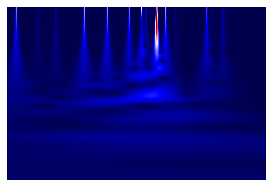

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00231.csv


<Figure size 432x288 with 0 Axes>

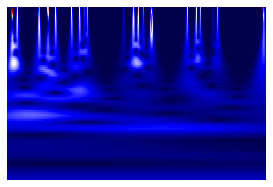

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00232.csv


<Figure size 432x288 with 0 Axes>

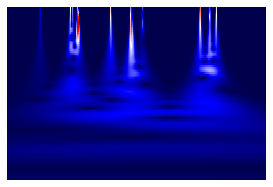

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00233.csv


<Figure size 432x288 with 0 Axes>

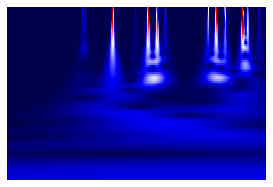

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00234.csv


<Figure size 432x288 with 0 Axes>

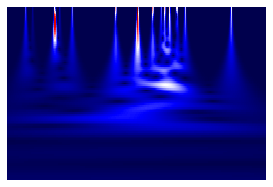

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00235.csv


<Figure size 432x288 with 0 Axes>

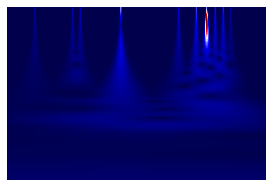

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00236.csv


<Figure size 432x288 with 0 Axes>

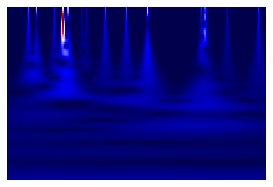

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00237.csv


<Figure size 432x288 with 0 Axes>

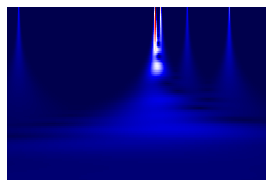

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00238.csv


<Figure size 432x288 with 0 Axes>

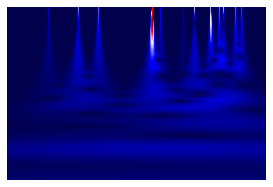

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00239.csv


<Figure size 432x288 with 0 Axes>

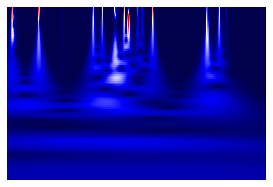

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00240.csv


<Figure size 432x288 with 0 Axes>

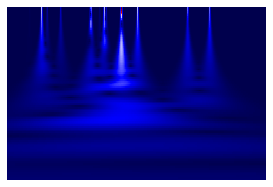

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00241.csv


<Figure size 432x288 with 0 Axes>

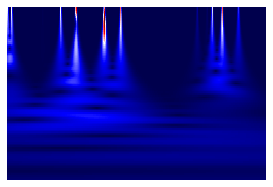

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00242.csv


<Figure size 432x288 with 0 Axes>

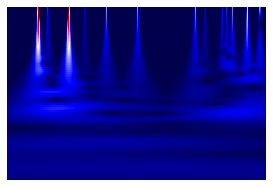

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00243.csv


<Figure size 432x288 with 0 Axes>

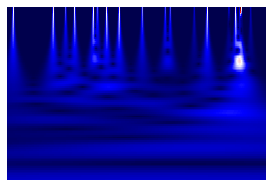

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00244.csv


<Figure size 432x288 with 0 Axes>

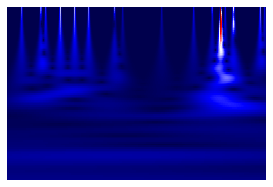

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00245.csv


<Figure size 432x288 with 0 Axes>

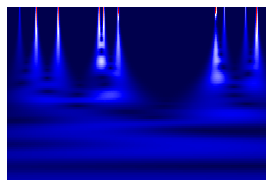

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00246.csv


<Figure size 432x288 with 0 Axes>

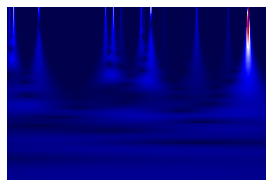

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00247.csv


<Figure size 432x288 with 0 Axes>

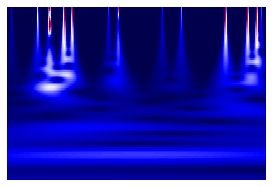

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00248.csv


<Figure size 432x288 with 0 Axes>

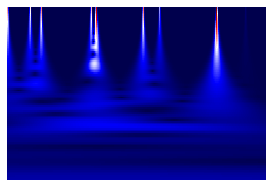

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00249.csv


<Figure size 432x288 with 0 Axes>

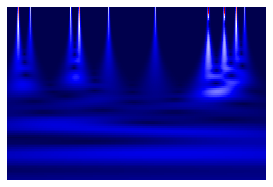

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00250.csv


<Figure size 432x288 with 0 Axes>

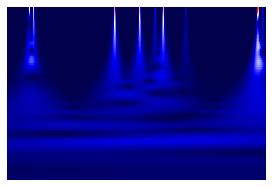

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00251.csv


<Figure size 432x288 with 0 Axes>

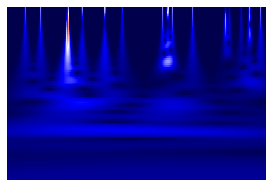

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00252.csv


<Figure size 432x288 with 0 Axes>

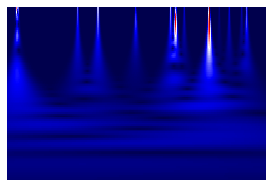

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00253.csv


<Figure size 432x288 with 0 Axes>

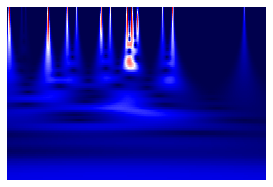

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00254.csv


<Figure size 432x288 with 0 Axes>

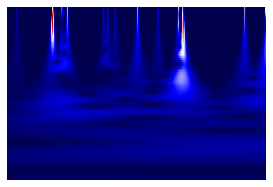

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00255.csv


<Figure size 432x288 with 0 Axes>

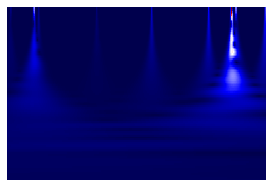

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00256.csv


<Figure size 432x288 with 0 Axes>

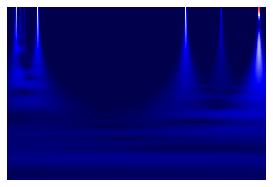

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00257.csv


<Figure size 432x288 with 0 Axes>

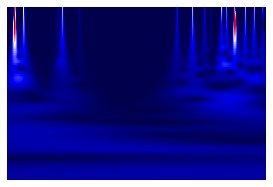

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00258.csv


<Figure size 432x288 with 0 Axes>

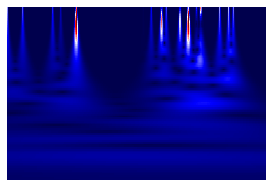

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00259.csv


<Figure size 432x288 with 0 Axes>

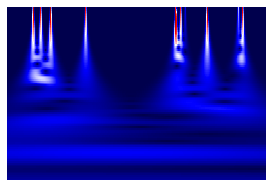

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00260.csv


<Figure size 432x288 with 0 Axes>

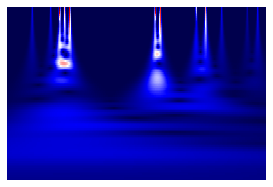

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00261.csv


<Figure size 432x288 with 0 Axes>

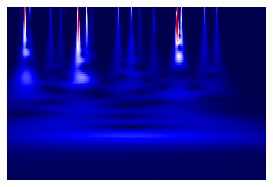

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00262.csv


<Figure size 432x288 with 0 Axes>

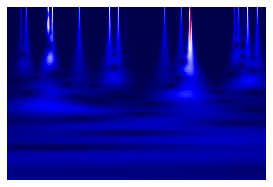

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00263.csv


<Figure size 432x288 with 0 Axes>

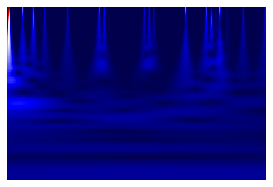

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00264.csv


<Figure size 432x288 with 0 Axes>

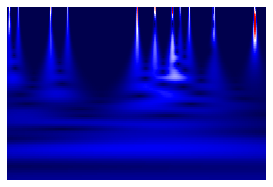

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00265.csv


<Figure size 432x288 with 0 Axes>

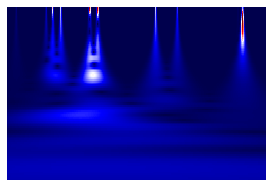

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00266.csv


<Figure size 432x288 with 0 Axes>

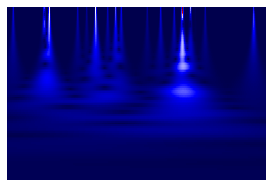

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00267.csv


<Figure size 432x288 with 0 Axes>

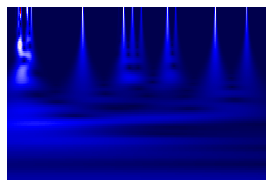

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00268.csv


<Figure size 432x288 with 0 Axes>

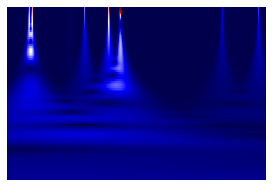

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00269.csv


<Figure size 432x288 with 0 Axes>

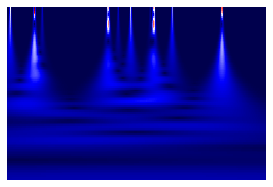

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00270.csv


<Figure size 432x288 with 0 Axes>

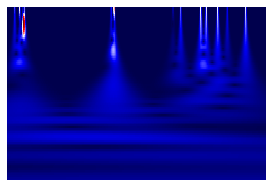

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00271.csv


<Figure size 432x288 with 0 Axes>

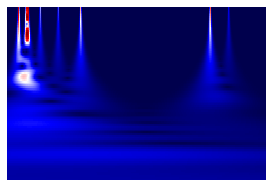

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00272.csv


<Figure size 432x288 with 0 Axes>

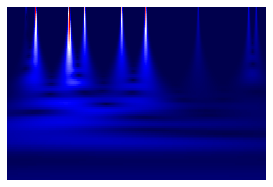

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00273.csv


<Figure size 432x288 with 0 Axes>

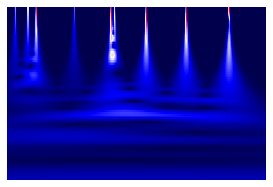

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00274.csv


<Figure size 432x288 with 0 Axes>

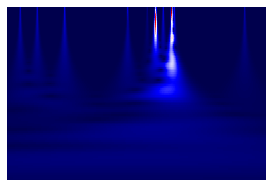

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00275.csv


<Figure size 432x288 with 0 Axes>

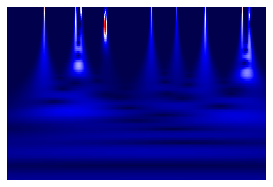

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00276.csv


<Figure size 432x288 with 0 Axes>

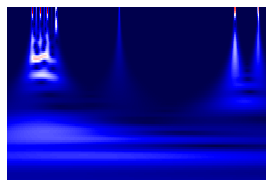

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00277.csv


<Figure size 432x288 with 0 Axes>

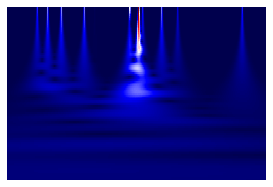

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00278.csv


<Figure size 432x288 with 0 Axes>

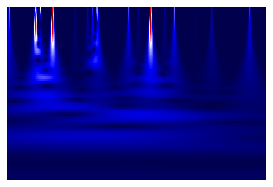

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00279.csv


<Figure size 432x288 with 0 Axes>

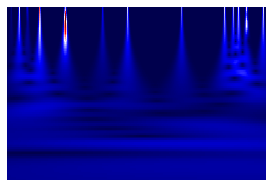

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00280.csv


<Figure size 432x288 with 0 Axes>

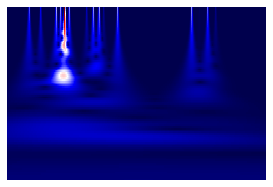

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00281.csv


<Figure size 432x288 with 0 Axes>

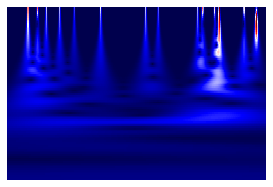

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00282.csv


<Figure size 432x288 with 0 Axes>

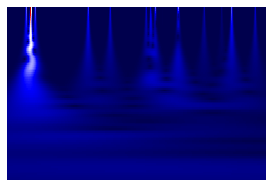

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00283.csv


<Figure size 432x288 with 0 Axes>

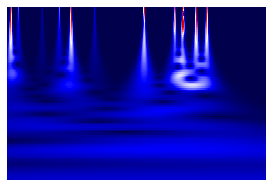

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00284.csv


<Figure size 432x288 with 0 Axes>

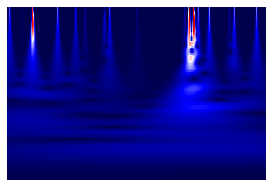

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00285.csv


<Figure size 432x288 with 0 Axes>

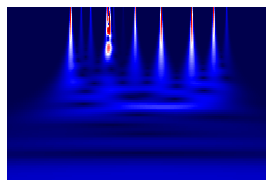

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00286.csv


<Figure size 432x288 with 0 Axes>

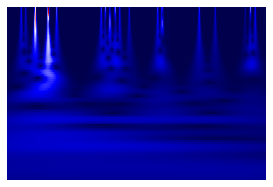

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00287.csv


<Figure size 432x288 with 0 Axes>

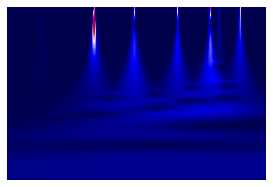

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00288.csv


<Figure size 432x288 with 0 Axes>

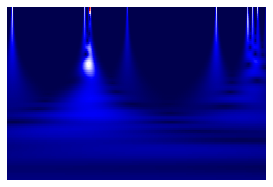

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00289.csv


<Figure size 432x288 with 0 Axes>

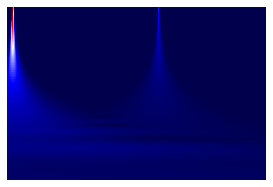

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00290.csv


<Figure size 432x288 with 0 Axes>

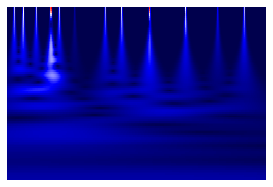

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00291.csv


<Figure size 432x288 with 0 Axes>

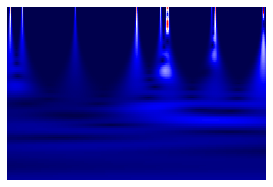

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00292.csv


<Figure size 432x288 with 0 Axes>

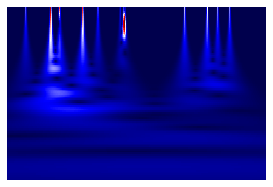

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00293.csv


<Figure size 432x288 with 0 Axes>

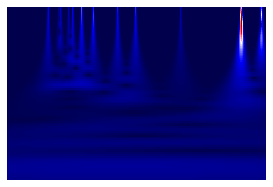

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00294.csv


<Figure size 432x288 with 0 Axes>

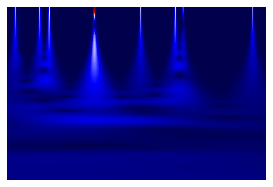

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00295.csv


<Figure size 432x288 with 0 Axes>

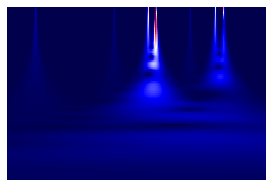

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00296.csv


<Figure size 432x288 with 0 Axes>

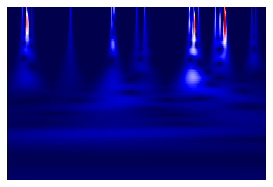

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00297.csv


<Figure size 432x288 with 0 Axes>

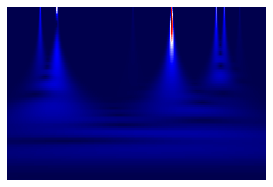

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00298.csv


<Figure size 432x288 with 0 Axes>

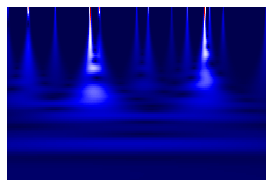

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00299.csv


<Figure size 432x288 with 0 Axes>

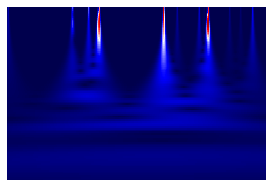

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00300.csv


<Figure size 432x288 with 0 Axes>

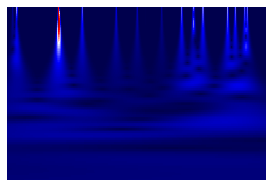

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00301.csv


<Figure size 432x288 with 0 Axes>

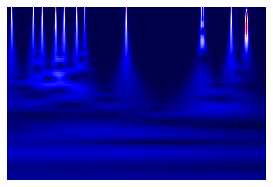

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00302.csv


<Figure size 432x288 with 0 Axes>

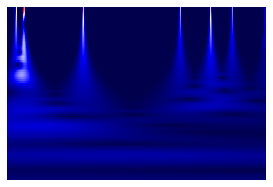

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00303.csv


<Figure size 432x288 with 0 Axes>

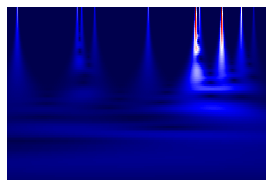

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00304.csv


<Figure size 432x288 with 0 Axes>

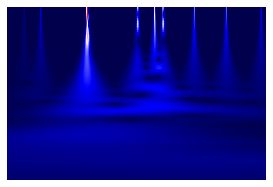

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00305.csv


<Figure size 432x288 with 0 Axes>

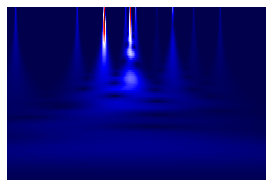

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00306.csv


<Figure size 432x288 with 0 Axes>

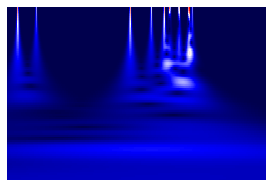

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00307.csv


<Figure size 432x288 with 0 Axes>

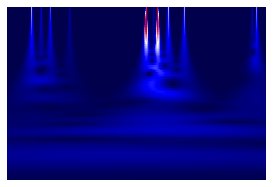

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00308.csv


<Figure size 432x288 with 0 Axes>

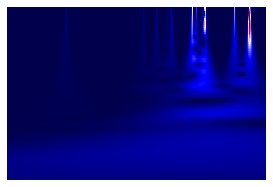

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00309.csv


<Figure size 432x288 with 0 Axes>

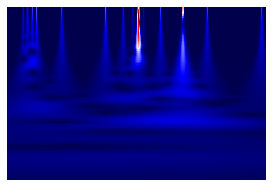

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00310.csv


<Figure size 432x288 with 0 Axes>

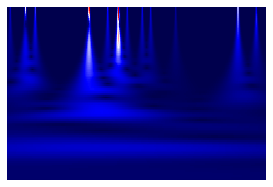

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00311.csv


<Figure size 432x288 with 0 Axes>

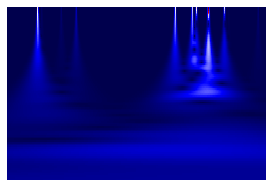

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00312.csv


<Figure size 432x288 with 0 Axes>

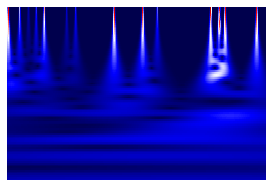

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00313.csv


<Figure size 432x288 with 0 Axes>

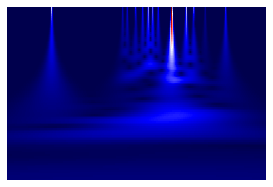

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00314.csv


<Figure size 432x288 with 0 Axes>

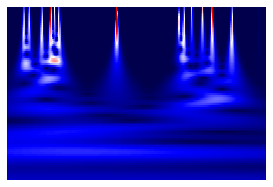

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00315.csv


<Figure size 432x288 with 0 Axes>

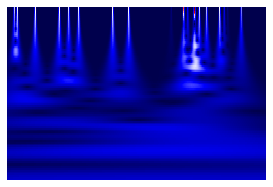

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00316.csv


<Figure size 432x288 with 0 Axes>

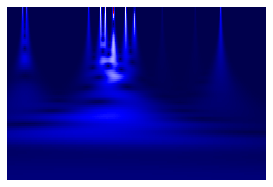

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00317.csv


<Figure size 432x288 with 0 Axes>

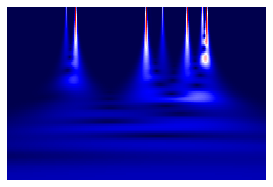

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00318.csv


<Figure size 432x288 with 0 Axes>

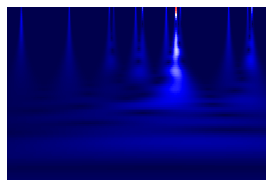

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00319.csv


<Figure size 432x288 with 0 Axes>

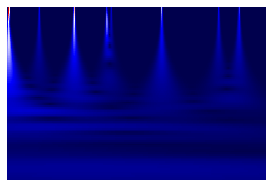

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00320.csv


<Figure size 432x288 with 0 Axes>

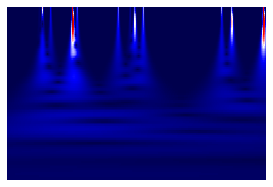

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00321.csv


<Figure size 432x288 with 0 Axes>

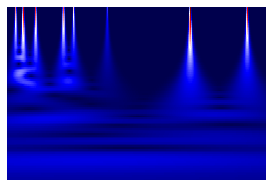

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00322.csv


<Figure size 432x288 with 0 Axes>

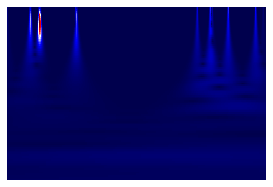

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00323.csv


<Figure size 432x288 with 0 Axes>

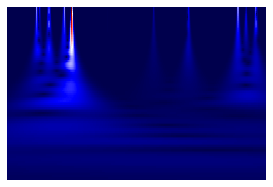

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00324.csv


<Figure size 432x288 with 0 Axes>

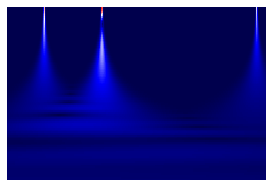

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00325.csv


<Figure size 432x288 with 0 Axes>

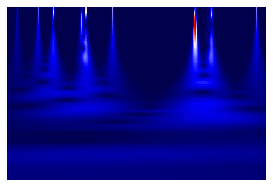

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00326.csv


<Figure size 432x288 with 0 Axes>

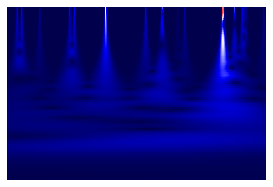

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00327.csv


<Figure size 432x288 with 0 Axes>

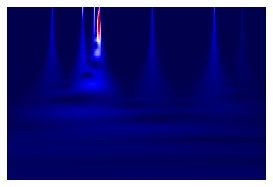

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00328.csv


<Figure size 432x288 with 0 Axes>

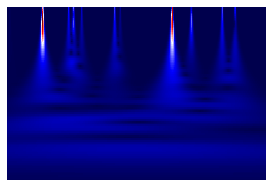

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00329.csv


<Figure size 432x288 with 0 Axes>

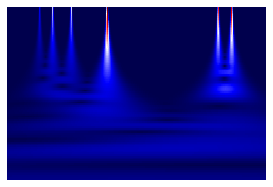

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00330.csv


<Figure size 432x288 with 0 Axes>

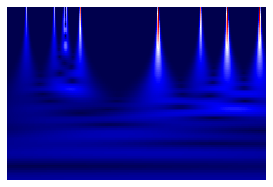

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00331.csv


<Figure size 432x288 with 0 Axes>

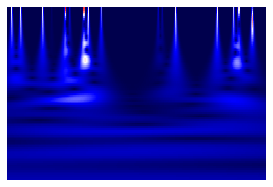

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00332.csv


<Figure size 432x288 with 0 Axes>

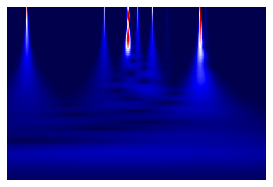

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00333.csv


<Figure size 432x288 with 0 Axes>

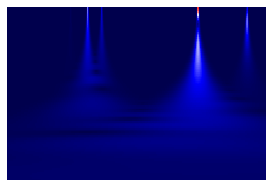

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00334.csv


<Figure size 432x288 with 0 Axes>

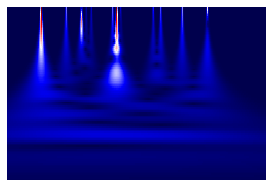

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00335.csv


<Figure size 432x288 with 0 Axes>

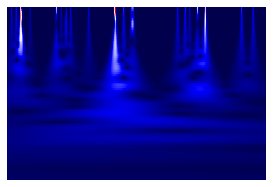

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00336.csv


<Figure size 432x288 with 0 Axes>

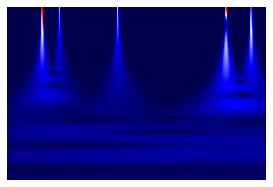

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00337.csv


<Figure size 432x288 with 0 Axes>

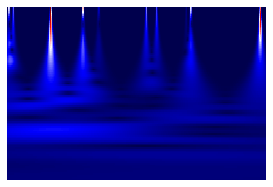

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00338.csv


<Figure size 432x288 with 0 Axes>

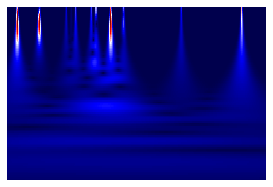

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00339.csv


<Figure size 432x288 with 0 Axes>

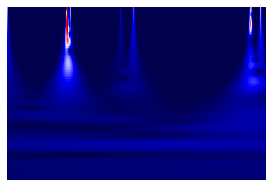

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00340.csv


<Figure size 432x288 with 0 Axes>

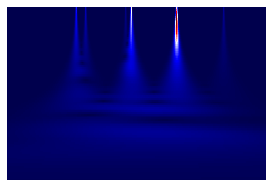

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00341.csv


<Figure size 432x288 with 0 Axes>

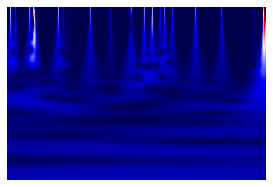

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00342.csv


<Figure size 432x288 with 0 Axes>

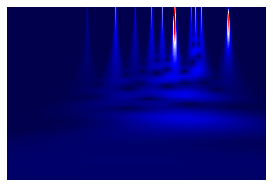

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00343.csv


<Figure size 432x288 with 0 Axes>

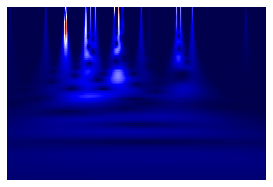

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00344.csv


<Figure size 432x288 with 0 Axes>

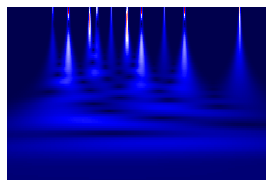

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00345.csv


<Figure size 432x288 with 0 Axes>

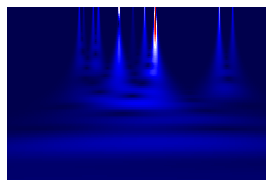

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00346.csv


<Figure size 432x288 with 0 Axes>

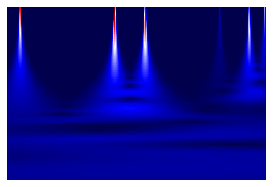

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00347.csv


<Figure size 432x288 with 0 Axes>

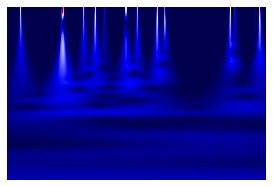

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00348.csv


<Figure size 432x288 with 0 Axes>

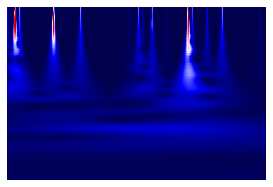

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00349.csv


<Figure size 432x288 with 0 Axes>

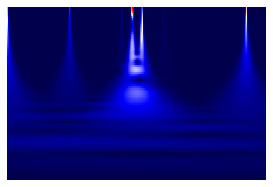

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00350.csv


<Figure size 432x288 with 0 Axes>

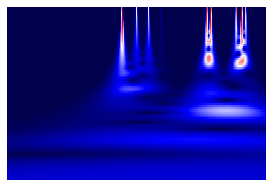

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00351.csv


<Figure size 432x288 with 0 Axes>

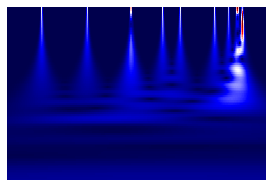

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00352.csv


<Figure size 432x288 with 0 Axes>

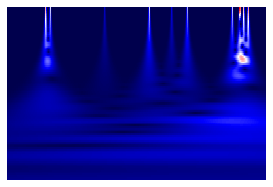

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00353.csv


<Figure size 432x288 with 0 Axes>

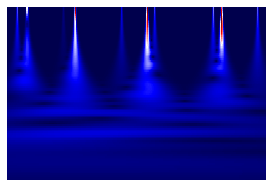

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00354.csv


<Figure size 432x288 with 0 Axes>

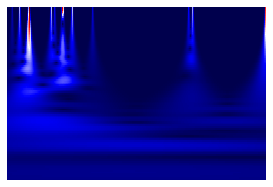

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00355.csv


<Figure size 432x288 with 0 Axes>

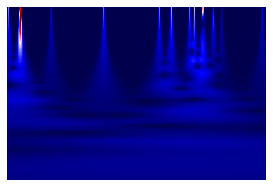

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00356.csv


<Figure size 432x288 with 0 Axes>

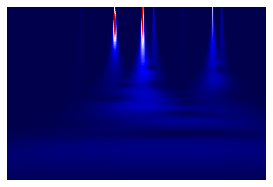

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00357.csv


<Figure size 432x288 with 0 Axes>

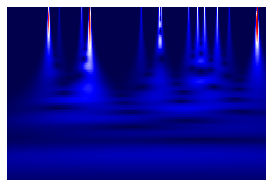

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00358.csv


<Figure size 432x288 with 0 Axes>

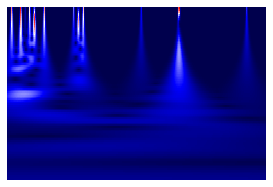

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00359.csv


<Figure size 432x288 with 0 Axes>

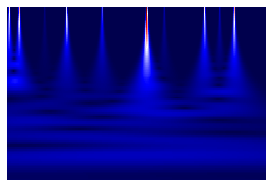

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00360.csv


<Figure size 432x288 with 0 Axes>

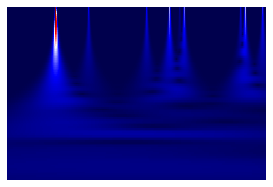

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00361.csv


<Figure size 432x288 with 0 Axes>

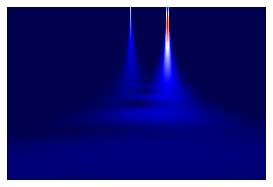

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00362.csv


<Figure size 432x288 with 0 Axes>

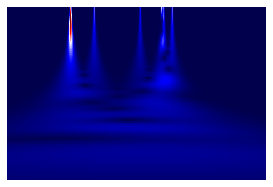

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00363.csv


<Figure size 432x288 with 0 Axes>

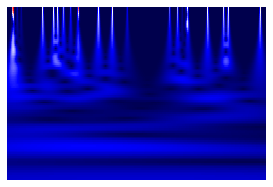

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00364.csv


<Figure size 432x288 with 0 Axes>

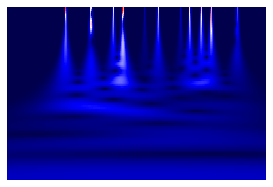

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00365.csv


<Figure size 432x288 with 0 Axes>

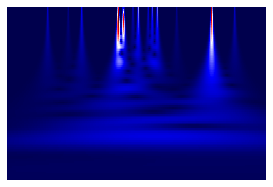

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00366.csv


<Figure size 432x288 with 0 Axes>

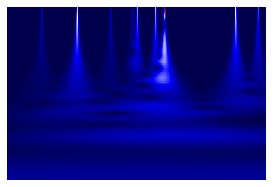

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00367.csv


<Figure size 432x288 with 0 Axes>

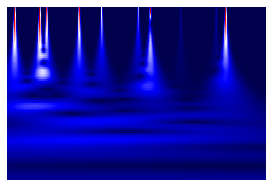

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00368.csv


<Figure size 432x288 with 0 Axes>

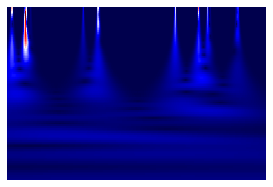

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00369.csv


<Figure size 432x288 with 0 Axes>

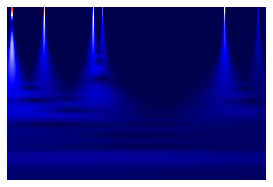

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00370.csv


<Figure size 432x288 with 0 Axes>

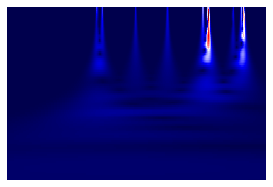

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00371.csv


<Figure size 432x288 with 0 Axes>

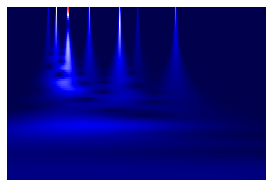

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00372.csv


<Figure size 432x288 with 0 Axes>

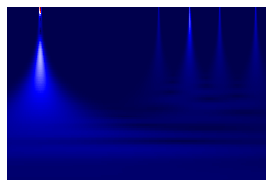

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00373.csv


<Figure size 432x288 with 0 Axes>

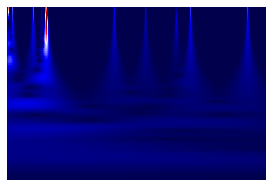

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00374.csv


<Figure size 432x288 with 0 Axes>

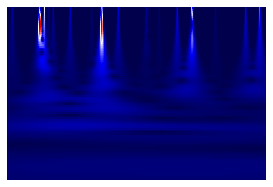

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00375.csv


<Figure size 432x288 with 0 Axes>

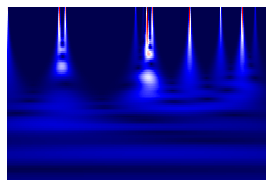

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00376.csv


<Figure size 432x288 with 0 Axes>

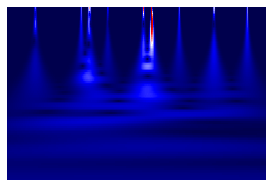

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00377.csv


<Figure size 432x288 with 0 Axes>

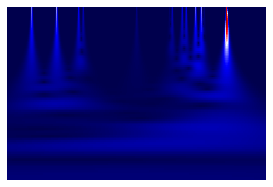

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00378.csv


<Figure size 432x288 with 0 Axes>

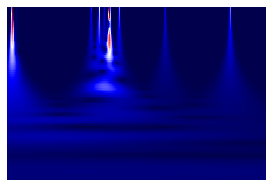

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00379.csv


<Figure size 432x288 with 0 Axes>

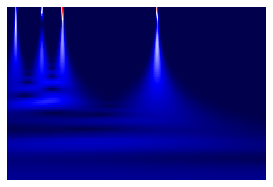

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00380.csv


<Figure size 432x288 with 0 Axes>

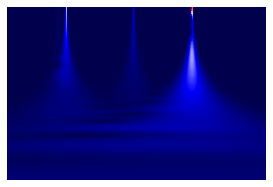

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00381.csv


<Figure size 432x288 with 0 Axes>

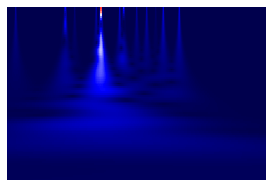

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00382.csv


<Figure size 432x288 with 0 Axes>

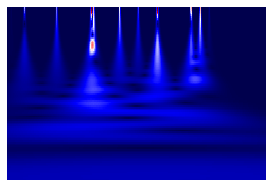

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00383.csv


<Figure size 432x288 with 0 Axes>

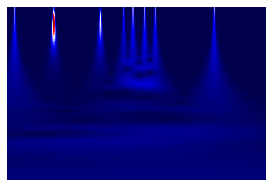

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00384.csv


<Figure size 432x288 with 0 Axes>

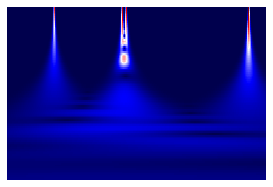

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00385.csv


<Figure size 432x288 with 0 Axes>

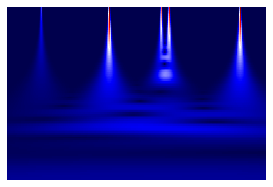

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00386.csv


<Figure size 432x288 with 0 Axes>

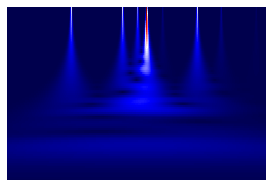

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00387.csv


<Figure size 432x288 with 0 Axes>

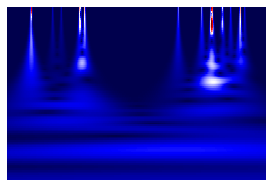

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00388.csv


<Figure size 432x288 with 0 Axes>

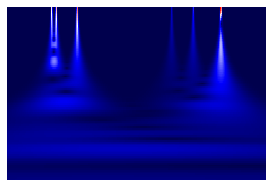

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00389.csv


<Figure size 432x288 with 0 Axes>

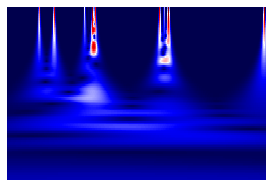

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00390.csv


<Figure size 432x288 with 0 Axes>

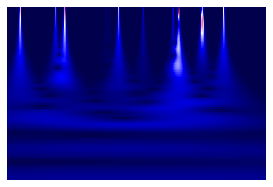

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00391.csv


<Figure size 432x288 with 0 Axes>

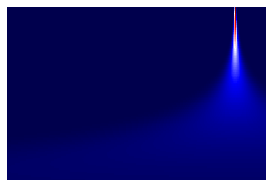

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00392.csv


<Figure size 432x288 with 0 Axes>

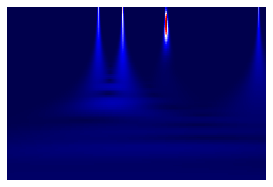

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00393.csv


<Figure size 432x288 with 0 Axes>

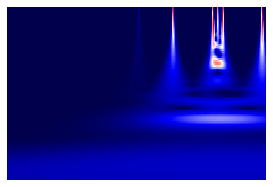

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00394.csv


<Figure size 432x288 with 0 Axes>

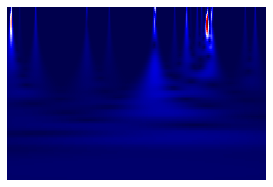

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00395.csv


<Figure size 432x288 with 0 Axes>

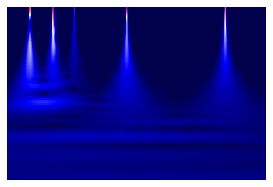

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00396.csv


<Figure size 432x288 with 0 Axes>

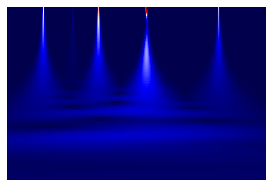

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00397.csv


<Figure size 432x288 with 0 Axes>

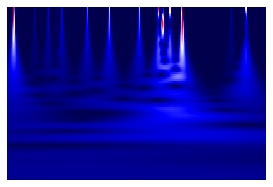

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00398.csv


<Figure size 432x288 with 0 Axes>

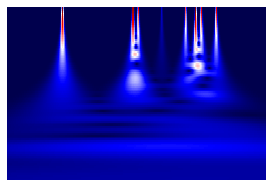

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00399.csv


<Figure size 432x288 with 0 Axes>

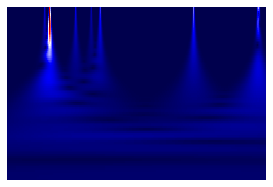

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00400.csv


<Figure size 432x288 with 0 Axes>

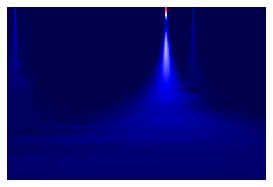

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00401.csv


<Figure size 432x288 with 0 Axes>

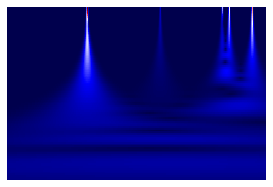

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00402.csv


<Figure size 432x288 with 0 Axes>

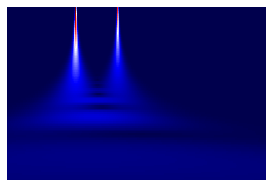

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00403.csv


<Figure size 432x288 with 0 Axes>

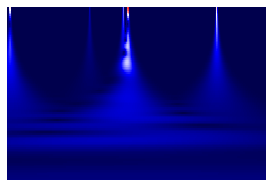

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00404.csv


<Figure size 432x288 with 0 Axes>

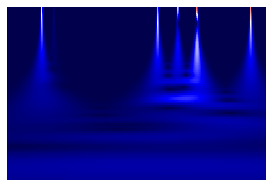

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00405.csv


<Figure size 432x288 with 0 Axes>

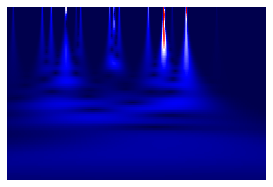

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00406.csv


<Figure size 432x288 with 0 Axes>

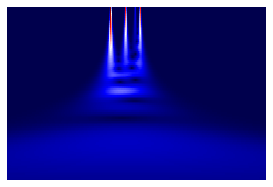

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00407.csv


<Figure size 432x288 with 0 Axes>

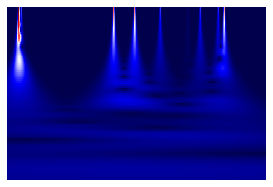

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00408.csv


<Figure size 432x288 with 0 Axes>

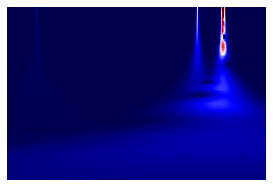

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00409.csv


<Figure size 432x288 with 0 Axes>

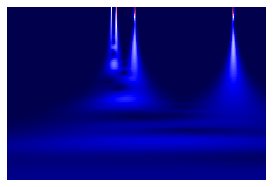

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00410.csv


<Figure size 432x288 with 0 Axes>

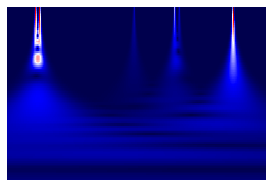

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00411.csv


<Figure size 432x288 with 0 Axes>

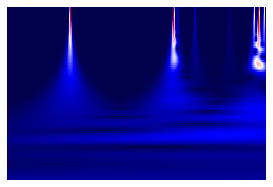

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00412.csv


<Figure size 432x288 with 0 Axes>

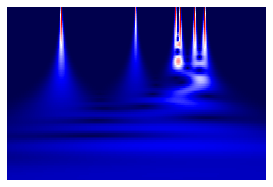

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00413.csv


<Figure size 432x288 with 0 Axes>

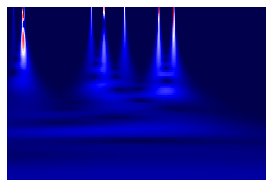

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00414.csv


<Figure size 432x288 with 0 Axes>

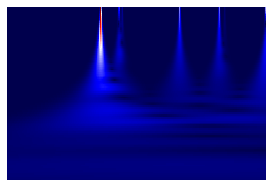

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00415.csv


<Figure size 432x288 with 0 Axes>

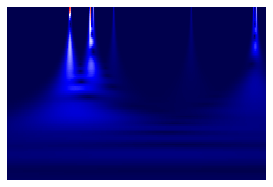

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00416.csv


<Figure size 432x288 with 0 Axes>

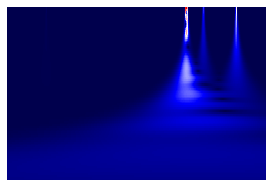

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00417.csv


<Figure size 432x288 with 0 Axes>

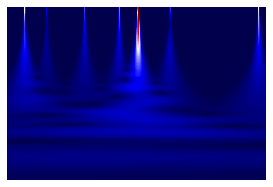

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00418.csv


<Figure size 432x288 with 0 Axes>

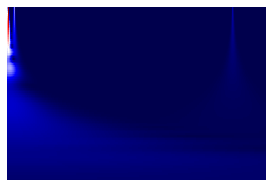

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00419.csv


<Figure size 432x288 with 0 Axes>

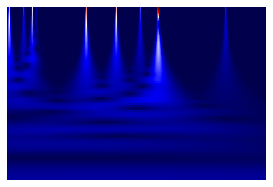

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00420.csv


<Figure size 432x288 with 0 Axes>

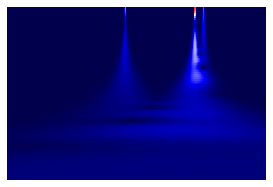

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00421.csv


<Figure size 432x288 with 0 Axes>

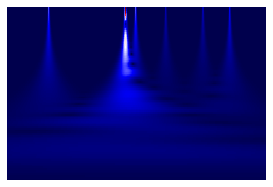

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00422.csv


<Figure size 432x288 with 0 Axes>

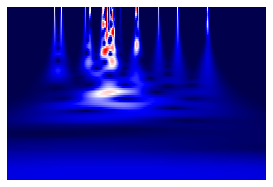

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00423.csv


<Figure size 432x288 with 0 Axes>

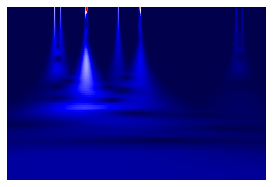

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00424.csv


<Figure size 432x288 with 0 Axes>

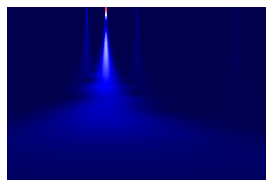

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00425.csv


<Figure size 432x288 with 0 Axes>

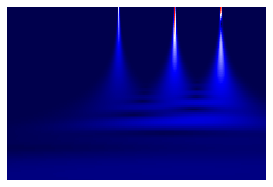

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00426.csv


<Figure size 432x288 with 0 Axes>

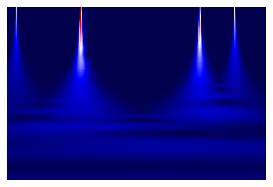

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00427.csv


<Figure size 432x288 with 0 Axes>

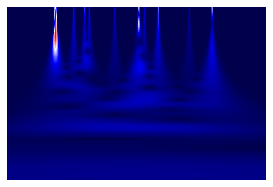

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00428.csv


<Figure size 432x288 with 0 Axes>

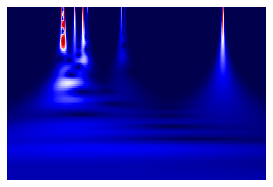

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00429.csv


<Figure size 432x288 with 0 Axes>

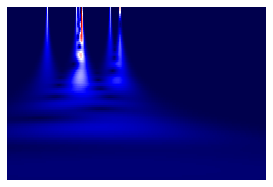

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00430.csv


<Figure size 432x288 with 0 Axes>

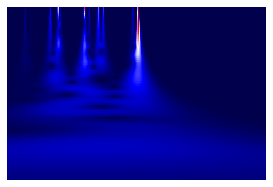

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00431.csv


<Figure size 432x288 with 0 Axes>

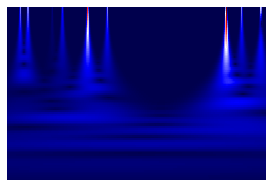

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00432.csv


<Figure size 432x288 with 0 Axes>

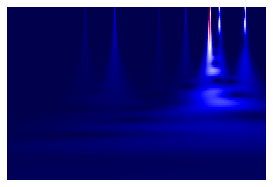

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00433.csv


<Figure size 432x288 with 0 Axes>

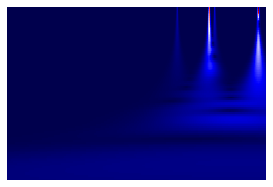

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00434.csv


<Figure size 432x288 with 0 Axes>

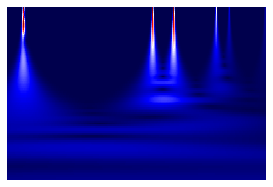

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00435.csv


<Figure size 432x288 with 0 Axes>

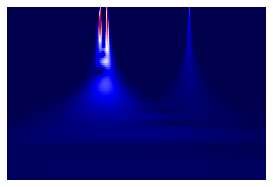

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00436.csv


<Figure size 432x288 with 0 Axes>

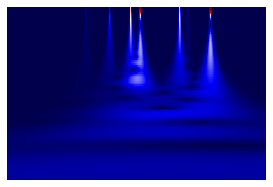

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00437.csv


<Figure size 432x288 with 0 Axes>

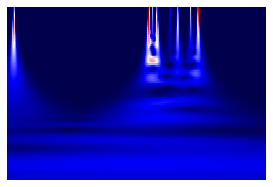

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00438.csv


<Figure size 432x288 with 0 Axes>

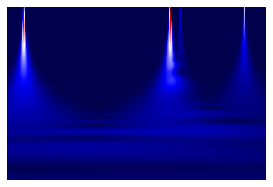

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00439.csv


<Figure size 432x288 with 0 Axes>

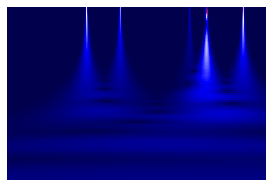

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00440.csv


<Figure size 432x288 with 0 Axes>

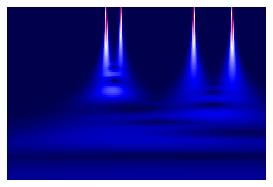

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00441.csv


<Figure size 432x288 with 0 Axes>

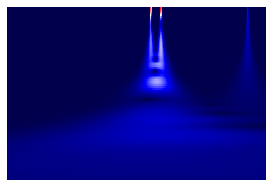

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00442.csv


<Figure size 432x288 with 0 Axes>

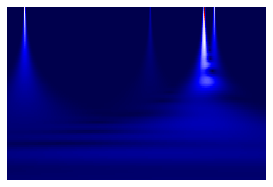

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00443.csv


<Figure size 432x288 with 0 Axes>

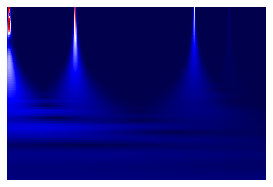

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00444.csv


<Figure size 432x288 with 0 Axes>

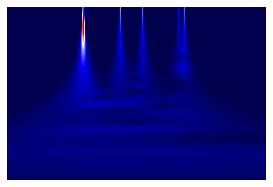

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00445.csv


<Figure size 432x288 with 0 Axes>

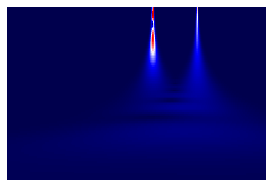

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00446.csv


<Figure size 432x288 with 0 Axes>

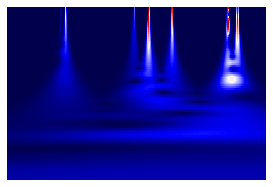

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00447.csv


<Figure size 432x288 with 0 Axes>

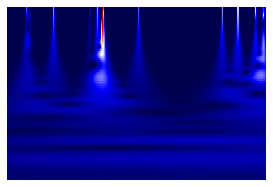

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00448.csv


<Figure size 432x288 with 0 Axes>

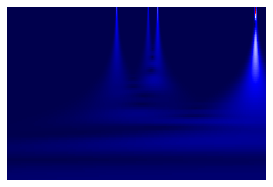

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00449.csv


<Figure size 432x288 with 0 Axes>

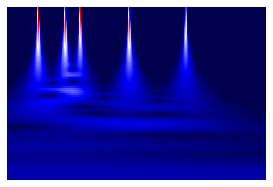

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00450.csv


<Figure size 432x288 with 0 Axes>

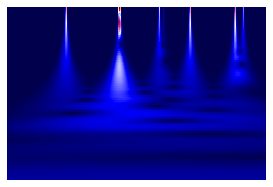

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00451.csv


<Figure size 432x288 with 0 Axes>

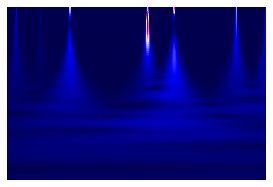

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00452.csv


<Figure size 432x288 with 0 Axes>

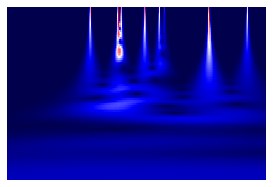

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00453.csv


<Figure size 432x288 with 0 Axes>

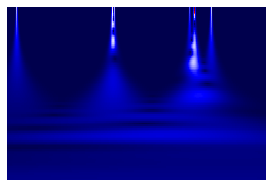

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00454.csv


<Figure size 432x288 with 0 Axes>

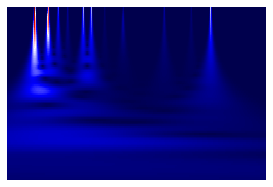

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00455.csv


<Figure size 432x288 with 0 Axes>

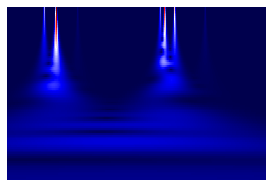

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00456.csv


<Figure size 432x288 with 0 Axes>

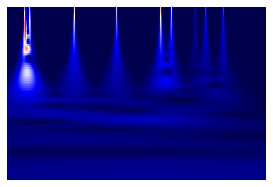

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00457.csv


<Figure size 432x288 with 0 Axes>

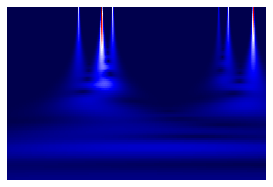

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00458.csv


<Figure size 432x288 with 0 Axes>

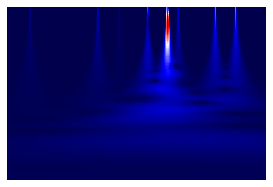

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00459.csv


<Figure size 432x288 with 0 Axes>

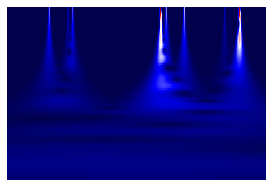

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00460.csv


<Figure size 432x288 with 0 Axes>

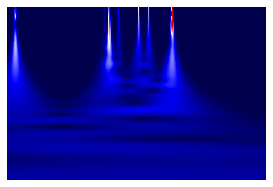

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00461.csv


<Figure size 432x288 with 0 Axes>

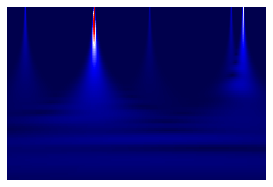

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00462.csv


<Figure size 432x288 with 0 Axes>

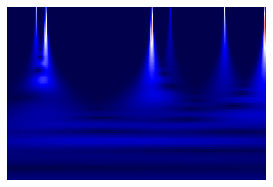

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00463.csv


<Figure size 432x288 with 0 Axes>

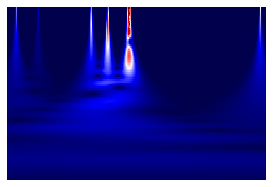

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00464.csv


<Figure size 432x288 with 0 Axes>

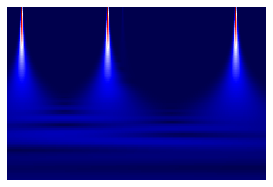

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00465.csv


<Figure size 432x288 with 0 Axes>

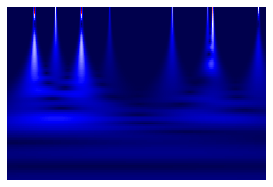

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00466.csv


<Figure size 432x288 with 0 Axes>

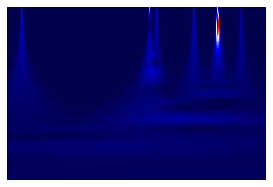

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00467.csv


<Figure size 432x288 with 0 Axes>

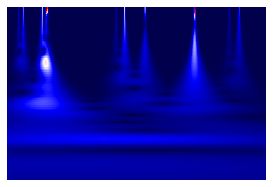

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00468.csv


<Figure size 432x288 with 0 Axes>

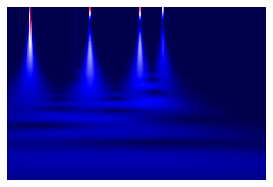

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00469.csv


<Figure size 432x288 with 0 Axes>

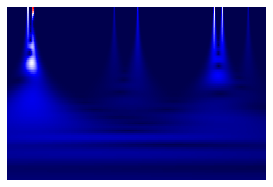

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00470.csv


<Figure size 432x288 with 0 Axes>

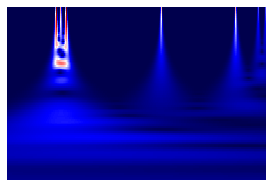

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00471.csv


<Figure size 432x288 with 0 Axes>

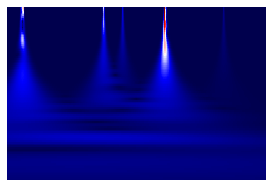

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00472.csv


<Figure size 432x288 with 0 Axes>

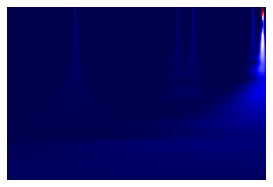

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00473.csv


<Figure size 432x288 with 0 Axes>

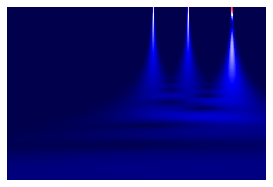

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00474.csv


<Figure size 432x288 with 0 Axes>

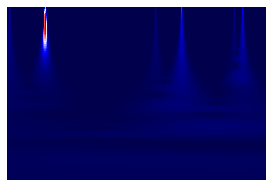

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00475.csv


<Figure size 432x288 with 0 Axes>

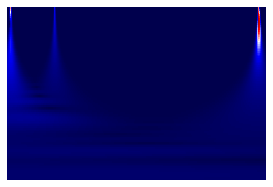

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00476.csv


<Figure size 432x288 with 0 Axes>

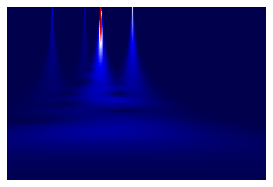

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00477.csv


<Figure size 432x288 with 0 Axes>

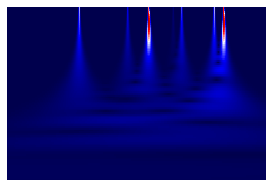

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00478.csv


<Figure size 432x288 with 0 Axes>

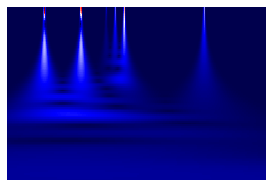

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00479.csv


<Figure size 432x288 with 0 Axes>

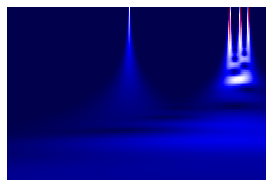

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00480.csv


<Figure size 432x288 with 0 Axes>

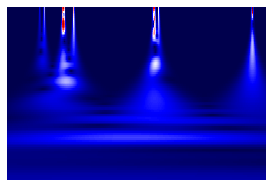

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00481.csv


<Figure size 432x288 with 0 Axes>

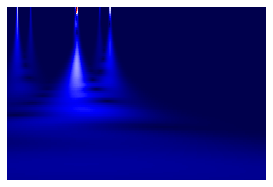

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00482.csv


<Figure size 432x288 with 0 Axes>

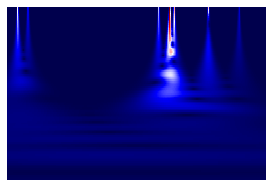

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00483.csv


<Figure size 432x288 with 0 Axes>

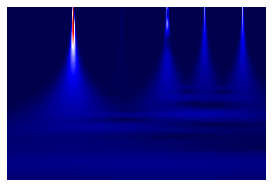

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00484.csv


<Figure size 432x288 with 0 Axes>

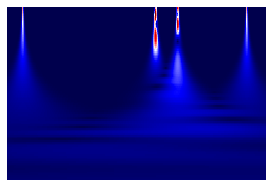

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00485.csv


<Figure size 432x288 with 0 Axes>

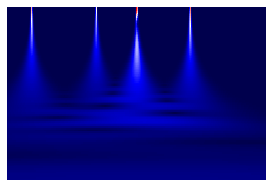

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00486.csv


<Figure size 432x288 with 0 Axes>

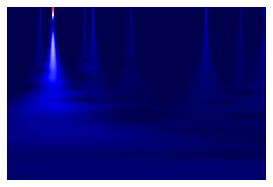

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00487.csv


<Figure size 432x288 with 0 Axes>

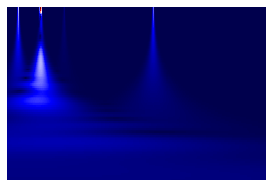

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00488.csv


<Figure size 432x288 with 0 Axes>

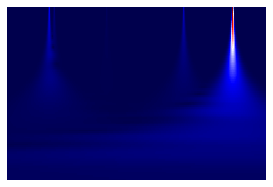

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00489.csv


<Figure size 432x288 with 0 Axes>

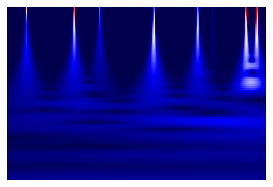

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00490.csv


<Figure size 432x288 with 0 Axes>

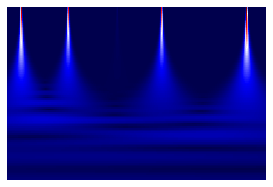

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00491.csv


<Figure size 432x288 with 0 Axes>

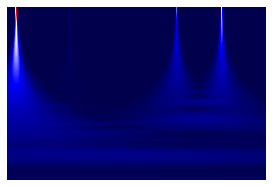

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00492.csv


<Figure size 432x288 with 0 Axes>

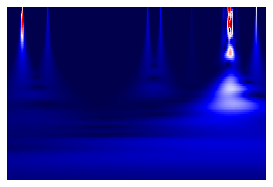

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00493.csv


<Figure size 432x288 with 0 Axes>

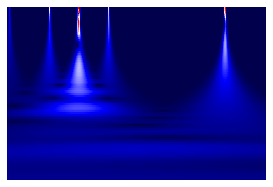

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00494.csv


<Figure size 432x288 with 0 Axes>

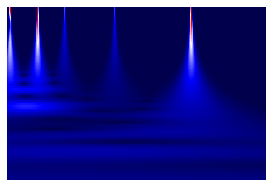

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00495.csv


<Figure size 432x288 with 0 Axes>

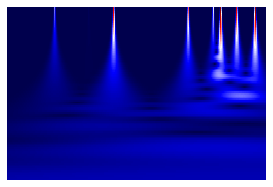

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00496.csv


<Figure size 432x288 with 0 Axes>

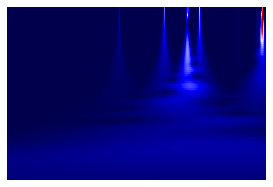

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00497.csv


<Figure size 432x288 with 0 Axes>

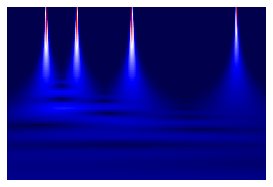

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00498.csv


<Figure size 432x288 with 0 Axes>

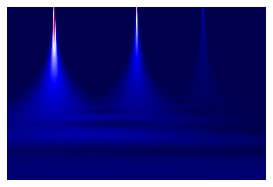

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00499.csv


<Figure size 432x288 with 0 Axes>

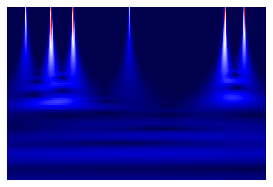

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00500.csv


<Figure size 432x288 with 0 Axes>

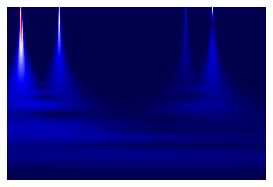

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00501.csv


<Figure size 432x288 with 0 Axes>

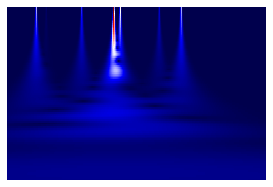

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00502.csv


<Figure size 432x288 with 0 Axes>

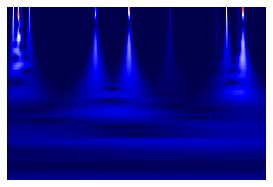

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00503.csv


<Figure size 432x288 with 0 Axes>

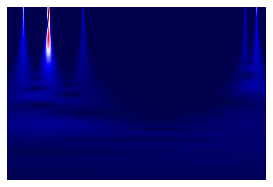

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00504.csv


<Figure size 432x288 with 0 Axes>

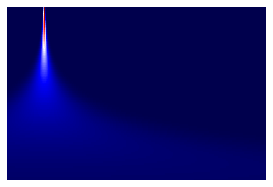

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00505.csv


<Figure size 432x288 with 0 Axes>

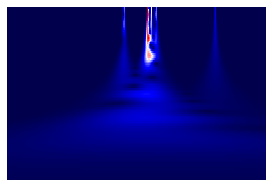

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00506.csv


<Figure size 432x288 with 0 Axes>

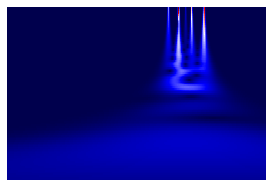

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00507.csv


<Figure size 432x288 with 0 Axes>

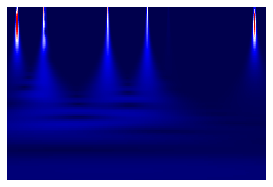

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00508.csv


<Figure size 432x288 with 0 Axes>

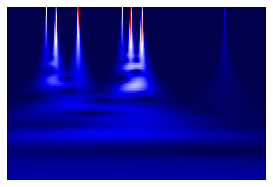

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00509.csv


<Figure size 432x288 with 0 Axes>

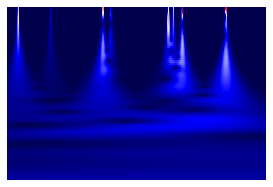

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00510.csv


<Figure size 432x288 with 0 Axes>

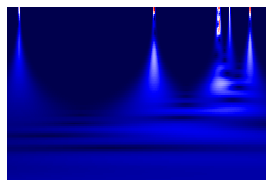

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00511.csv


<Figure size 432x288 with 0 Axes>

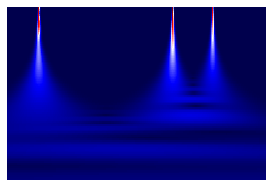

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00512.csv


<Figure size 432x288 with 0 Axes>

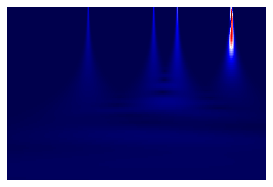

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00513.csv


<Figure size 432x288 with 0 Axes>

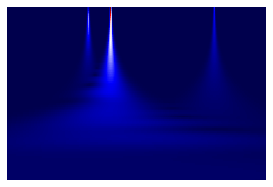

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00514.csv


<Figure size 432x288 with 0 Axes>

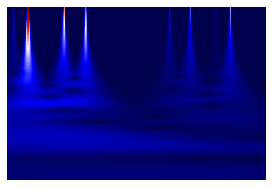

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00515.csv


<Figure size 432x288 with 0 Axes>

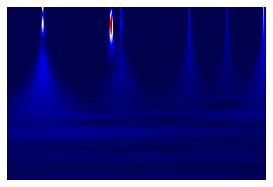

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00516.csv


<Figure size 432x288 with 0 Axes>

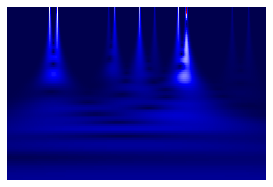

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00517.csv


<Figure size 432x288 with 0 Axes>

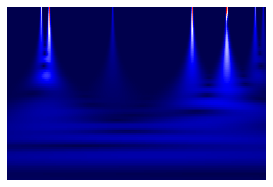

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00518.csv


<Figure size 432x288 with 0 Axes>

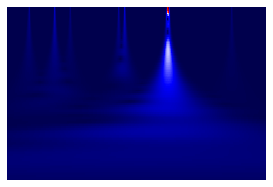

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00519.csv


<Figure size 432x288 with 0 Axes>

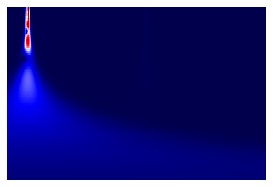

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00520.csv


<Figure size 432x288 with 0 Axes>

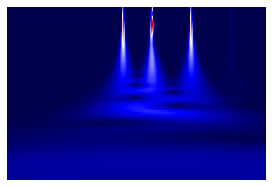

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00521.csv


<Figure size 432x288 with 0 Axes>

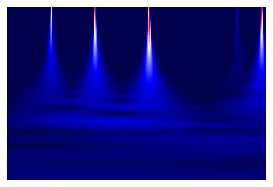

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00522.csv


<Figure size 432x288 with 0 Axes>

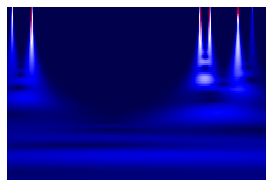

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00523.csv


<Figure size 432x288 with 0 Axes>

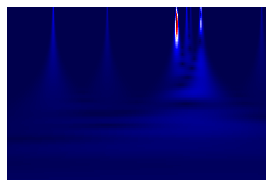

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00524.csv


<Figure size 432x288 with 0 Axes>

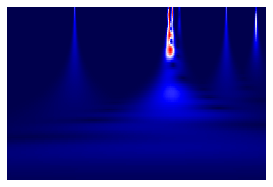

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00525.csv


<Figure size 432x288 with 0 Axes>

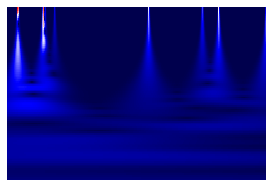

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00526.csv


<Figure size 432x288 with 0 Axes>

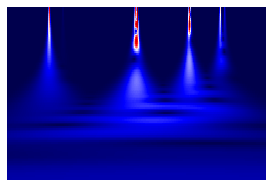

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00527.csv


<Figure size 432x288 with 0 Axes>

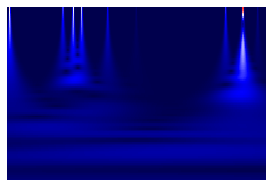

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00528.csv


<Figure size 432x288 with 0 Axes>

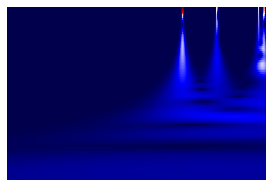

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00529.csv


<Figure size 432x288 with 0 Axes>

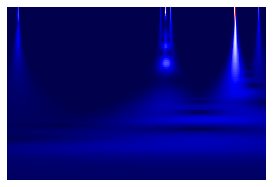

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00530.csv


<Figure size 432x288 with 0 Axes>

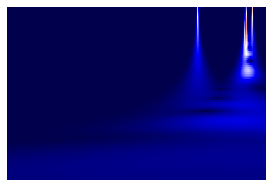

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00531.csv


<Figure size 432x288 with 0 Axes>

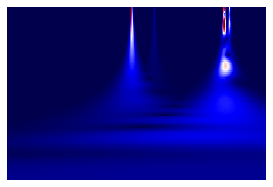

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00532.csv


<Figure size 432x288 with 0 Axes>

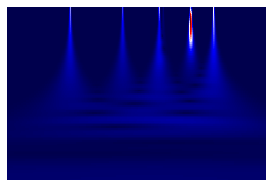

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00533.csv


<Figure size 432x288 with 0 Axes>

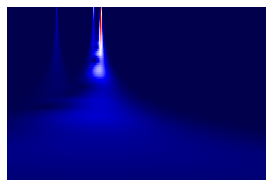

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00534.csv


<Figure size 432x288 with 0 Axes>

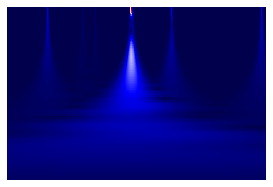

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00535.csv


<Figure size 432x288 with 0 Axes>

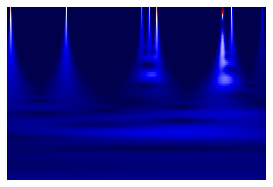

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00536.csv


<Figure size 432x288 with 0 Axes>

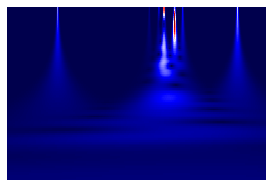

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00537.csv


<Figure size 432x288 with 0 Axes>

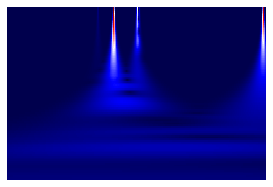

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00538.csv


<Figure size 432x288 with 0 Axes>

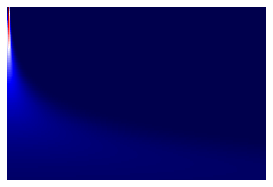

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00539.csv


<Figure size 432x288 with 0 Axes>

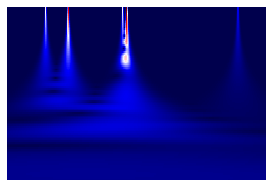

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00540.csv


<Figure size 432x288 with 0 Axes>

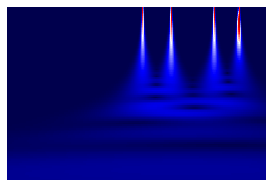

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00541.csv


<Figure size 432x288 with 0 Axes>

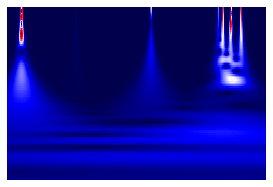

../datasets/phm-2012/Learning_set/Bearing1_1/acc_00542.csv


<Figure size 432x288 with 0 Axes>

In [ ]:
#empty numpy array to store the training data set 
x_train = np.zeros((len(onlyfiles), 511, 99))
y_train = np.zeros((len(onlyfiles)))

c=0

dt = 0.0001
fmin = 10
fmax = 10000

for file in onlyfiles:
    if int(file.split('_')[1].split('.')[0]) % 1 == 0:

        print(load_path+file)
        
        b11_pd = pd.read_csv(load_path+file, header=None)
        img = plot_tfr(plot_wps(b11_pd[4].tail(512).values), 
                 dt=dt, 
                 fmin=fmin, 
                 fmax=fmax, 
                 cmap='seismic',
                 figure_name = motor + '_' + file.split('.')[0])

        # sa
        wt_np = img.get_array().reshape(img._meshWidth, img._meshHeight)
        x_train[c, :, :] = wt_np
        y_train[c] = float(int(file.split('.')[0].split('_')[1])/len(onlyfiles))
        c=c+1

In [ ]:
#reshape to include depth
X_train = x_train.reshape(x_train.shape[0], 1, 511,99)
#convert to float32 and normalize to [0,1]
X_train = X_train.astype('float32')
Y_train = y_train.astype('float32')
X_train /= np.amax(X_train)

In [ ]:
#save dataset as numpy file

x = npy_save_path+'X_train_'+motor+'.npy'
y = npy_save_path+'Y_train_'+motor+'.npy'

print (x)
print (y)

np.save(x, X_train)
np.save(y, Y_train)


In [ ]:
fig, ax = plt.subplots()
ax.plot(Y_train)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')

ax.grid()

plt.show()